In [1]:
# Aanlyze single-cell TCR data
# 2021-02-0
# Fan Zhang

In [14]:
# library(immunarch)

In [3]:
# Load data
# "/data/srlab/bwh10x/190913_KW7393_10x_rawbcl/cellranger-3.1.0/GRCh38/"
# BRI-470 fluid - BRI-468 paired pbmc
# BRI-474 fluid - BRI-472 paired pbmc

# https://support.10xgenomics.com/single-cell-vdj/software/pipelines/latest/output/annotation

In [42]:
# file_path = "/data/srlab/bwh10x/190913_KW7393_10x_rawbcl/cellranger-3.1.0/GRCh38/"

In [ ]:
# immdata_10x <- repLoad(file_path)


== Step 1/3: loading repertoire files... ==



In [34]:
# immdata_10x$meta

[1] 3637   19

Clones,Proportion,CDR3.nt,CDR3.aa
238,0.046703297,TGTGCCGTGTTCTTACCTACCGGCACTGCCAGTAAACTCACCTTT;TGCGCCAGCAGCTGGACGACAGACCTAAATTACAATGAGCAGTTCTTC,CAVFLPTGTASKLTF;CASSWTTDLNYNEQFF
71,0.013932496,TGTGCCGTGTTCTTACCTACCGGCACTGCCAGTAAACTCACCTTT;TGCAGCAAGCGCGAAACTGGCAACACAGGCAAACTAATCTTT;TGCGCCAGCAGCTGGACGACAGACCTAAATTACAATGAGCAGTTCTTC,CAVFLPTGTASKLTF;CSKRETGNTGKLIF;CASSWTTDLNYNEQFF
71,0.013932496,TGTGTGGTTTTTCCTGGGCGGGAATATGGAAACAAACTGGTCTTT;TGTGCCAGTAGTTTCCGGGAGAAGGTGATCACCGGGGAGCTGTTTTTT,CVVFPGREYGNKLVF;CASSFREKVITGELFF
46,0.009026688,TGCGCCAGCAGCTGGACGACAGACCTAAATTACAATGAGCAGTTCTTC,CASSWTTDLNYNEQFF


[1] "Sample"

Sample
filtered_contig_annotations


In [4]:
# https://github.com/ncborcherding/scRepertoire
# scRepertoire: https://ncborcherding.github.io/vignettes/vignette.html
# https://www.biostars.org/p/384640/

In [4]:
library(scRepertoire)
library(monocle3)
library(ggplot2)
library(Seurat)
library(harmony)
library(magrittr)
library(gridExtra)
library(ggthemes)
library(reticulate)
library(ggbeeswarm)
library(ggrepel)
library(plyr)
library(ggplot2)
library(gridExtra)
library(ggthemes)
library(dplyr)
library(RColorBrewer)
library(ggbeeswarm)
library(ggrepel)
library(MASS)
library(matrixStats)
library(viridis)
library(grid)
library(singlecellmethods)
library(umap)
library(ggpubr)

paste5 <- function(..., sep = " ", collapse = NULL, na.rm = F) {
  if (na.rm == F)
    paste(..., sep = sep, collapse = collapse)
  else
    if (na.rm == T) {
      paste.na <- function(x, sep) {
        x <- gsub("^\\s+|\\s+$", "", x)
        ret <- paste(na.omit(x), collapse = sep)
        is.na(ret) <- ret == ""
        return(ret)
      }
      df <- data.frame(..., stringsAsFactors = F)
      ret <- apply(df, 1, FUN = function(x) paste.na(x, sep))

      if (is.null(collapse))
        ret
      else {
        paste.na(ret, sep = collapse)
      }
    }
}
     

In [3]:
# # BRI-470 fluid - BRI-468 paired pbmc
# # BRI-474 fluid - BRI-472 paired pbmc

# fluid_470 <- read.csv("/data/srlab/bwh10x/190913_KW7393_10x_rawbcl/cellranger-3.1.0/GRCh38/BRI-470/outs/filtered_contig_annotations.csv", stringsAsFactors = F)
# fluid_474 <- read.csv("/data/srlab/bwh10x/190913_KW7393_10x_rawbcl/cellranger-3.1.0/GRCh38/BRI-474/outs/filtered_contig_annotations.csv", stringsAsFactors = F)
# pbmc_468 <- read.csv("/data/srlab/bwh10x/190913_KW7393_10x_rawbcl/cellranger-3.1.0/GRCh38/BRI-468/outs/filtered_contig_annotations.csv", stringsAsFactors = F)
# pbmc_472 <- read.csv("/data/srlab/bwh10x/190913_KW7393_10x_rawbcl/cellranger-3.1.0/GRCh38/BRI-472/outs/filtered_contig_annotations.csv", stringsAsFactors = F)

fluid_470 <- read.csv("/data/srlab2/fzhang/results/2021_02_08_TCR_CD8/GRCh38/BRI-470/outs/filtered_contig_annotations.csv", stringsAsFactors = F)
fluid_474 <- read.csv("/data/srlab2/fzhang/results/2021_02_08_TCR_CD8/GRCh38/BRI-474/outs/filtered_contig_annotations.csv", stringsAsFactors = F)
pbmc_468 <- read.csv("/data/srlab2/fzhang/results/2021_02_08_TCR_CD8/GRCh38/BRI-468/outs/filtered_contig_annotations.csv", stringsAsFactors = F)
pbmc_472 <- read.csv("/data/srlab2/fzhang/results/2021_02_08_TCR_CD8/GRCh38/BRI-472/outs/filtered_contig_annotations.csv", stringsAsFactors = F)

In [7]:
colnames(fluid_470)

[1] "barcode"          "is_cell"          "contig_id"        "high_confidence" 
 [5] "length"           "chain"            "v_gene"           "d_gene"          
 [9] "j_gene"           "c_gene"           "full_length"      "productive"      
[13] "cdr3"             "cdr3_nt"          "reads"            "umis"            
[17] "raw_clonotype_id" "raw_consensus_id"

In [15]:
# Create a object
contig_list <- list(fluid_470, fluid_474, pbmc_468, pbmc_472)

In [16]:
colnames(contig_list[[1]])

[1] "barcode"          "is_cell"          "contig_id"        "high_confidence" 
 [5] "length"           "chain"            "v_gene"           "d_gene"          
 [9] "j_gene"           "c_gene"           "full_length"      "productive"      
[13] "cdr3"             "cdr3_nt"          "reads"            "umis"            
[17] "raw_clonotype_id" "raw_consensus_id"

In [17]:
# data("contig_list") #the data built into scRepertoire
head(contig_list[[1]])

,barcode,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,full_length,productive,cdr3,cdr3_nt,reads,umis,raw_clonotype_id,raw_consensus_id
,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>
1,AAACCTGAGTAACCCT-1,True,AAACCTGAGTAACCCT-1_contig_1,True,550,TRA,TRAV12-2,None,TRAJ44,TRAC,True,True,CAVFLPTGTASKLTF,TGTGCCGTGTTCTTACCTACCGGCACTGCCAGTAAACTCACCTTT,2386,6,clonotype1,clonotype1_consensus_1
2,AAACCTGAGTAACCCT-1,True,AAACCTGAGTAACCCT-1_contig_2,True,506,TRB,TRBV5-1,None,TRBJ2-1,TRBC2,True,True,CASSWTTDLNYNEQFF,TGCGCCAGCAGCTGGACGACAGACCTAAATTACAATGAGCAGTTCTTC,2456,8,clonotype1,clonotype1_consensus_2
3,AAACCTGAGTAACCCT-1,True,AAACCTGAGTAACCCT-1_contig_3,True,384,TRB,None,None,TRBJ1-5,TRBC1,False,False,None,None,1054,3,clonotype1,None
4,AAACCTGCAGTTCCCT-1,True,AAACCTGCAGTTCCCT-1_contig_1,True,511,TRA,TRAV29/DV5,None,TRAJ42,TRAC,True,True,CAASAEGGSQGNLIF,TGTGCAGCAAGCGCGGAGGGAGGAAGCCAAGGAAATCTCATCTTT,284,5,clonotype20,clonotype20_consensus_1
5,AAACCTGCAGTTCCCT-1,True,AAACCTGCAGTTCCCT-1_contig_2,True,650,TRB,TRBV5-4,None,TRBJ1-2,TRBC1,True,True,CASSPWTGGYGYTF,TGTGCCAGCAGCCCCTGGACAGGCGGGTATGGCTACACCTTC,1852,8,clonotype20,clonotype20_consensus_2
6,AAACCTGCAGTTCCCT-1,True,AAACCTGCAGTTCCCT-1_contig_3,True,320,TRB,None,None,TRBJ1-6,TRBC1,False,False,None,None,628,1,clonotype20,None


In [18]:
# As the output of CellRanger are quantifications of both the TCRA and TCRB chains,
# the next step is to create a single list object with the TCR gene and CDR3 sequences by cell barcode. This is performed using the combineTCR(), where the input is the stripped contig_list. 
# There is also the relabeling of the barcodes by sample and ID information to prevent duplicates.

combined <- combineTCR(contig_list, samples = c("P012", "P090", "P012", "P090"), ID = c("fluid_470", "fluid_474", "pbmc_468", "pbmc_472"), cells ="T-AB")

In [20]:
class(combined)
length(combined)
dim(combined$P012_fluid_470)
dim(combined$P012_pbmc_468)
combined$P012_fluid_470[1:4,]
combined$P012_pbmc_468[1:4,]

[1] "list"

[1] 4

[1] 5096   14

[1] 5191   14

,barcode,sample,ID,TCR1,cdr3_aa1,cdr3_nt1,TCR2,cdr3_aa2,cdr3_nt2,CTgene,CTnt,CTaa,CTstrict,cellType
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,P012_fluid_470_AAACCTGAGTAACCCT-1,P012,fluid_470,TRAV12-2.TRAJ44.TRAC,CAVFLPTGTASKLTF,TGTGCCGTGTTCTTACCTACCGGCACTGCCAGTAAACTCACCTTT,TRBV5-1.TRBJ2-1.None.TRBC2,CASSWTTDLNYNEQFF,TGCGCCAGCAGCTGGACGACAGACCTAAATTACAATGAGCAGTTCTTC,TRAV12-2.TRAJ44.TRAC_TRBV5-1.TRBJ2-1.None.TRBC2,TGTGCCGTGTTCTTACCTACCGGCACTGCCAGTAAACTCACCTTT_TGCGCCAGCAGCTGGACGACAGACCTAAATTACAATGAGCAGTTCTTC,CAVFLPTGTASKLTF_CASSWTTDLNYNEQFF,TRAV12-2.TRAJ44.TRAC_TGTGCCGTGTTCTTACCTACCGGCACTGCCAGTAAACTCACCTTT_TRBV5-1.TRBJ2-1.None.TRBC2_TGCGCCAGCAGCTGGACGACAGACCTAAATTACAATGAGCAGTTCTTC,T-AB
3,P012_fluid_470_AAACCTGCAGTTCCCT-1,P012,fluid_470,TRAV29/DV5.TRAJ42.TRAC,CAASAEGGSQGNLIF,TGTGCAGCAAGCGCGGAGGGAGGAAGCCAAGGAAATCTCATCTTT,TRBV5-4.TRBJ1-2.None.TRBC1,CASSPWTGGYGYTF,TGTGCCAGCAGCCCCTGGACAGGCGGGTATGGCTACACCTTC,TRAV29/DV5.TRAJ42.TRAC_TRBV5-4.TRBJ1-2.None.TRBC1,TGTGCAGCAAGCGCGGAGGGAGGAAGCCAAGGAAATCTCATCTTT_TGTGCCAGCAGCCCCTGGACAGGCGGGTATGGCTACACCTTC,CAASAEGGSQGNLIF_CASSPWTGGYGYTF,TRAV29/DV5.TRAJ42.TRAC_TGTGCAGCAAGCGCGGAGGGAGGAAGCCAAGGAAATCTCATCTTT_TRBV5-4.TRBJ1-2.None.TRBC1_TGTGCCAGCAGCCCCTGGACAGGCGGGTATGGCTACACCTTC,T-AB
5,P012_fluid_470_AAACCTGCATACTCTT-1,P012,fluid_470,TRAV5.TRAJ49.TRAC,CAESNTGNQFYF,TGTGCAGAGAGTAACACCGGTAACCAGTTCTATTTT,TRBV4-2.TRBJ2-2.None.TRBC2,CASSQDLLTGELFF,TGTGCCAGCAGCCAAGATCTGCTAACCGGGGAGCTGTTTTTT,TRAV5.TRAJ49.TRAC_TRBV4-2.TRBJ2-2.None.TRBC2,TGTGCAGAGAGTAACACCGGTAACCAGTTCTATTTT_TGTGCCAGCAGCCAAGATCTGCTAACCGGGGAGCTGTTTTTT,CAESNTGNQFYF_CASSQDLLTGELFF,TRAV5.TRAJ49.TRAC_TGTGCAGAGAGTAACACCGGTAACCAGTTCTATTTT_TRBV4-2.TRBJ2-2.None.TRBC2_TGTGCCAGCAGCCAAGATCTGCTAACCGGGGAGCTGTTTTTT,T-AB
7,P012_fluid_470_AAACCTGGTTATCGGT-1,P012,fluid_470,TRAV12-2.TRAJ52.TRAC;TRAV27.TRAJ28.TRAC,CAVNAGGTSYGKLTF;CAGDSYSGAGSYQLTF,TGTGCCGTCAATGCTGGTGGTACTAGCTATGGAAAGCTGACATTT;TGTGCAGGGGATTCATACTCTGGGGCTGGGAGTTACCAACTCACTTTC,NA,NA,NA,TRAV12-2.TRAJ52.TRAC;TRAV27.TRAJ28.TRAC_NA,TGTGCCGTCAATGCTGGTGGTACTAGCTATGGAAAGCTGACATTT;TGTGCAGGGGATTCATACTCTGGGGCTGGGAGTTACCAACTCACTTTC_NA,CAVNAGGTSYGKLTF;CAGDSYSGAGSYQLTF_NA,TRAV12-2.TRAJ52.TRAC;TRAV27.TRAJ28.TRAC_TGTGCCGTCAATGCTGGTGGTACTAGCTATGGAAAGCTGACATTT;TGTGCAGGGGATTCATACTCTGGGGCTGGGAGTTACCAACTCACTTTC_NA_NA,T-AB


,barcode,sample,ID,TCR1,cdr3_aa1,cdr3_nt1,TCR2,cdr3_aa2,cdr3_nt2,CTgene,CTnt,CTaa,CTstrict,cellType
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,P012_pbmc_468_AAACCTGAGAACAACT-1,P012,pbmc_468,TRAV13-1.TRAJ49.TRAC,CAASRGNQFYF,TGTGCAGCAAGTCGGGGTAACCAGTTCTATTTT,TRBV6-5.TRBJ2-1.None.TRBC2,CASSYSSGYREQFF,TGTGCCAGCAGTTACTCTTCGGGCTACAGGGAGCAGTTCTTC,TRAV13-1.TRAJ49.TRAC_TRBV6-5.TRBJ2-1.None.TRBC2,TGTGCAGCAAGTCGGGGTAACCAGTTCTATTTT_TGTGCCAGCAGTTACTCTTCGGGCTACAGGGAGCAGTTCTTC,CAASRGNQFYF_CASSYSSGYREQFF,TRAV13-1.TRAJ49.TRAC_TGTGCAGCAAGTCGGGGTAACCAGTTCTATTTT_TRBV6-5.TRBJ2-1.None.TRBC2_TGTGCCAGCAGTTACTCTTCGGGCTACAGGGAGCAGTTCTTC,T-AB
3,P012_pbmc_468_AAACCTGAGATCCCAT-1,P012,pbmc_468,TRAV17.TRAJ40.TRAC,CATDEPGTYKYIF,TGTGCTACGGACGAACCGGGAACCTACAAATACATCTTT,TRBV18.TRBJ1-1.None.TRBC1,CASSTWGLRGTEAFF,TGTGCCAGCTCCACATGGGGGCTCCGGGGCACTGAAGCTTTCTTT,TRAV17.TRAJ40.TRAC_TRBV18.TRBJ1-1.None.TRBC1,TGTGCTACGGACGAACCGGGAACCTACAAATACATCTTT_TGTGCCAGCTCCACATGGGGGCTCCGGGGCACTGAAGCTTTCTTT,CATDEPGTYKYIF_CASSTWGLRGTEAFF,TRAV17.TRAJ40.TRAC_TGTGCTACGGACGAACCGGGAACCTACAAATACATCTTT_TRBV18.TRBJ1-1.None.TRBC1_TGTGCCAGCTCCACATGGGGGCTCCGGGGCACTGAAGCTTTCTTT,T-AB
5,P012_pbmc_468_AAACCTGAGGCCATAG-1,P012,pbmc_468,TRAV13-1.TRAJ49.TRAC,CAASRGNQFYF,TGTGCAGCAAGTCGGGGTAACCAGTTCTATTTT,TRBV6-5.TRBJ2-1.None.TRBC2,CASSYSSGYREQFF,TGTGCCAGCAGTTACTCTTCGGGCTACAGGGAGCAGTTCTTC,TRAV13-1.TRAJ49.TRAC_TRBV6-5.TRBJ2-1.None.TRBC2,TGTGCAGCAAGTCGGGGTAACCAGTTCTATTTT_TGTGCCAGCAGTTACTCTTCGGGCTACAGGGAGCAGTTCTTC,CAASRGNQFYF_CASSYSSGYREQFF,TRAV13-1.TRAJ49.TRAC_TGTGCAGCAAGTCGGGGTAACCAGTTCTATTTT_TRBV6-5.TRBJ2-1.None.TRBC2_TGTGCCAGCAGTTACTCTTCGGGCTACAGGGAGCAGTTCTTC,T-AB
7,P012_pbmc_468_AAACCTGAGTCGCCGT-1,P012,pbmc_468,TRAV13-1.TRAJ49.TRAC,CAASRGNQFYF,TGTGCAGCAAGTCGGGGTAACCAGTTCTATTTT,TRBV6-5.TRBJ2-1.None.TRBC2,CASSYSSGYREQFF,TGTGCCAGCAGTTACTCTTCGGGCTACAGGGAGCAGTTCTTC,TRAV13-1.TRAJ49.TRAC_TRBV6-5.TRBJ2-1.None.TRBC2,TGTGCAGCAAGTCGGGGTAACCAGTTCTATTTT_TGTGCCAGCAGTTACTCTTCGGGCTACAGGGAGCAGTTCTTC,CAASRGNQFYF_CASSYSSGYREQFF,TRAV13-1.TRAJ49.TRAC_TGTGCAGCAAGTCGGGGTAACCAGTTCTATTTT_TRBV6-5.TRBJ2-1.None.TRBC2_TGTGCCAGCAGTTACTCTTCGGGCTACAGGGAGCAGTTCTTC,T-AB


In [21]:
# Visualizing Contigs
# cloneCall
# * "gene" - use the genes comprising the TCR/Ig
# * "nt" - use the nucleotide sequence of the CDR3 region
# * "aa" - use the amino acid sequence of the CDR3 region
# * "gene+nt" - use the genes comprising the TCR/Ig + the nucleotide sequence of the CDR3 region. This is the proper definition of clonotype.

Warning message:
"`fun.y` is deprecated. Use `fun` instead."


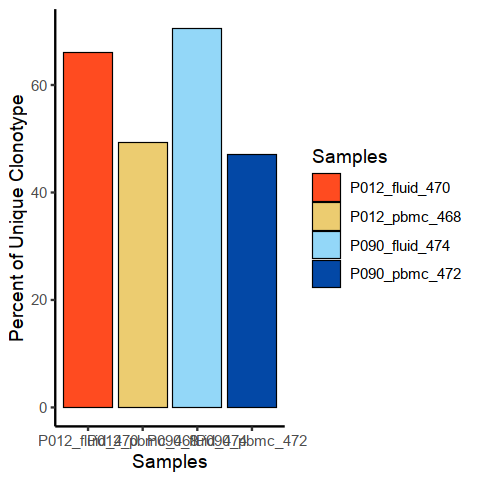

In [21]:
# quantContig() to return the total or relative numbers of unique clonotypes.
# relative percent of unique clonotypes scaled by total size of the clonotype repertoire

options(repr.plot.height = 4, repr.plot.width = 4)
quantContig(combined, cloneCall="gene+nt", scale = T)

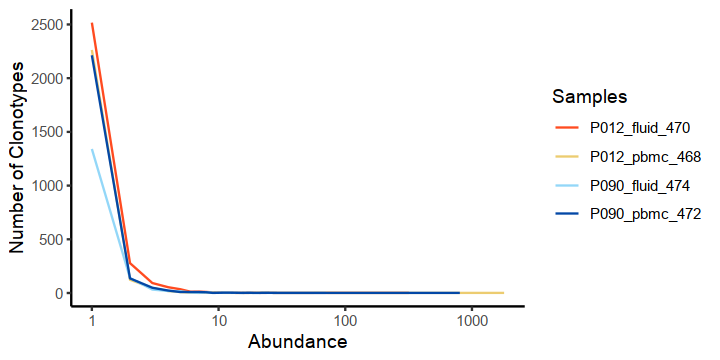

In [22]:
# examine the relative distribution of clonotypes by abundance.
# a total number of clonotypes by the number of instances within the sample or run
options(repr.plot.height = 3, repr.plot.width = 6)
abundanceContig(combined, cloneCall = "gene", scale = F)

In [23]:
abundanceContig(combined, cloneCall = "gene", exportTable = T)[1:10,]

CTgene,Abundance,values
<chr>,<int>,<chr>
NA;TRAV1-1.TRAJ44.TRAC_TRBV20-1.TRBJ2-7.None.TRBC2,1,P012_fluid_470
NA;TRAV1-1.TRAJ8.TRAC_TRBV4-2.TRBJ1-5.None.TRBC1,1,P012_fluid_470
NA;TRAV1-2.TRAJ15.TRAC_TRBV7-8.TRBJ2-1.None.TRBC2,1,P012_fluid_470
NA;TRAV1-2.TRAJ30.TRAC_TRBV7-9.TRBJ2-7.None.TRBC2,1,P012_fluid_470
NA;TRAV1-2.TRAJ33.TRAC_TRBV2.TRBJ2-2.None.TRBC2,1,P012_fluid_470
NA;TRAV10.TRAJ31.TRAC_TRBV11-2.TRBJ1-2.None.TRBC1,1,P012_fluid_470
NA;TRAV12-1.TRAJ31.TRAC_TRBV9.TRBJ2-1.None.TRBC2,1,P012_fluid_470
NA;TRAV12-2.TRAJ13.TRAC_TRBV3-1.TRBJ2-5.None.TRBC2,1,P012_fluid_470
NA;TRAV12-2.TRAJ39.TRAC_TRBV7-2.TRBJ2-1.None.TRBC2,1,P012_fluid_470


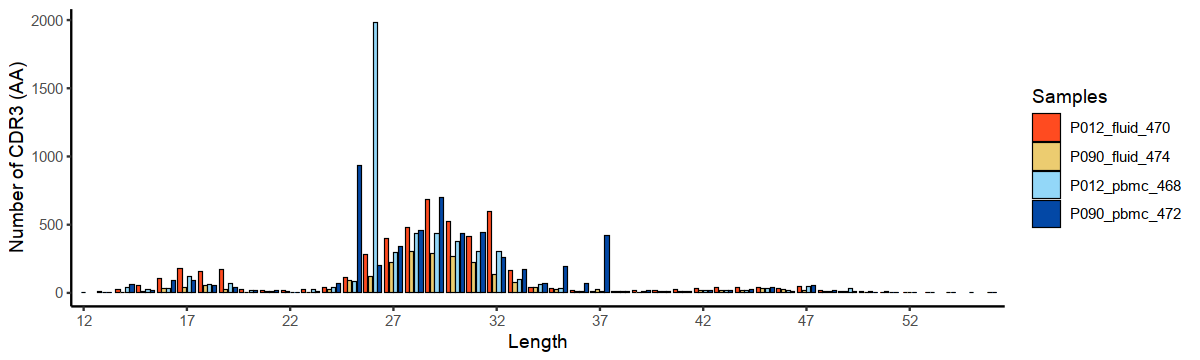

In [37]:
# look at the length distribution of the CDR3 sequences by calling the lengtheContig() function
# Importantly, unlike the other basic visualizations, the cloneCall can only be "nt" or "aa". 
# Due to the method of calling clonotypes as outlined above, the length should reveal a multimodal curve, 
# this is a product of using the NA for the unreturned chain sequence and multiple chains within a single barcode.

options(repr.plot.height = 3, repr.plot.width = 10)
lengthContig(combined, cloneCall="aa", chains = "combined") 

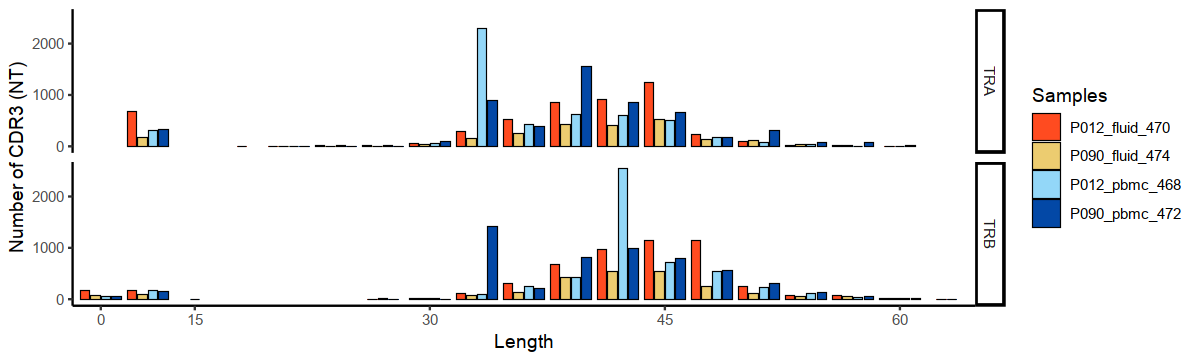

In [38]:
# Or we can visualize the individual chains of the immune receptors by selecting chains = "single". 
# Notably this will remove the NA component of combined clonotypes, so visualize is only the sequences recovered in the 
# filtered contig annotation file from Cell Ranger.

lengthContig(combined, cloneCall="nt", chains = "single") 

Warning message:
"The `.dots` argument of `group_by()` is deprecated as of dplyr 1.0.0.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated."


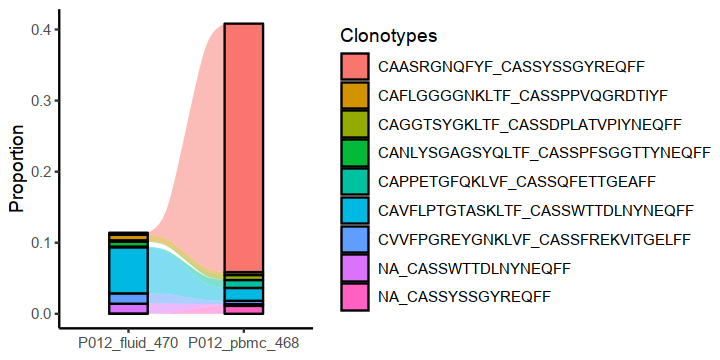

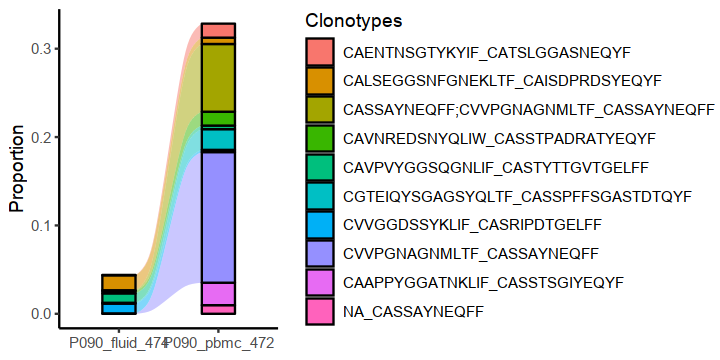

In [24]:
# We can also look at clonotypes between samples and changes in dynamics by using the compareClonotypes() function.
# Expanded clones in synovial fluid: (the same with the ones from Helena!)
# CAVFLPTGTASKLTF_CASSWTTDLNYNEQFF
# CVVFPGREYGNKLVF_CASSFREKVITGELFF
# CAFLGGGGNKLTF_CASSDPLATVPIYNEQFF

options(repr.plot.height = 3, repr.plot.width = 6)
compareClonotypes(combined, numbers = 10, samples = c("P012_pbmc_468", "P012_fluid_470"), cloneCall="aa", graph = "alluvial")


# CALSEGGSNFGNEKLTF_CAISDPRDSYEQYF
# CVVGGDSSYKLIF_CASRIPDTGELFF
# CAVPVYGGSQGNLIF_CASTYTTGVTGELFF
compareClonotypes(combined, numbers = 10, samples = c("P090_pbmc_472", "P090_fluid_474"), cloneCall="aa", graph = "alluvial")

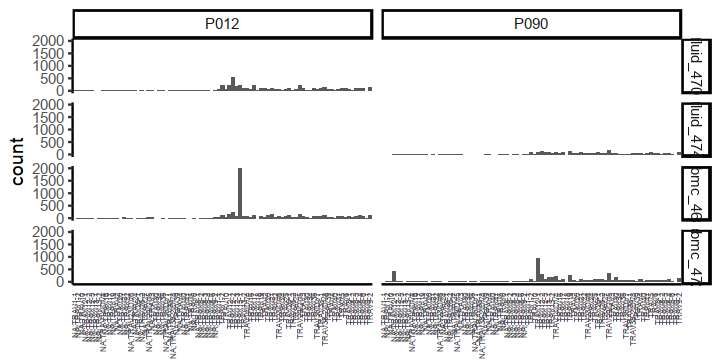

In [46]:
# Last of the basic analysis visualizations is the relative usage of vgenes of the TCR, using vizVgenes().
# TCR
# * For T-AB: TCR1 == TCRA and TCR2 == TCRB
# * For T-GD: TCR1 == TCRG and TCR2 == TCRD

vizVgenes(combined, TCR="TCR1", facet.x = "sample", facet.y = "ID")

,Rare (0 < X <= 1e-04),Small (1e-04 < X <= 0.001),Medium (0.001 < X <= 0.01),Large (0.01 < X <= 0.1),Hyperexpanded (0.1 < X <= 1)
P012_fluid_470,0,0.7231455,0.18342116,0.09343332,0.0000000
P090_fluid_474,0,0.7207648,0.22543353,0.05380169,0.0000000
P012_pbmc_468,0,0.5389560,0.07148422,0.04012466,0.3494351
P090_pbmc_472,0,0.5102266,0.17486641,0.16712733,0.1477796


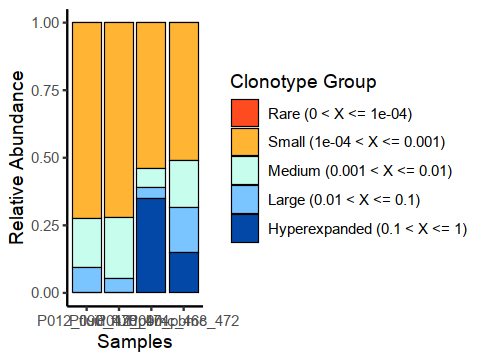

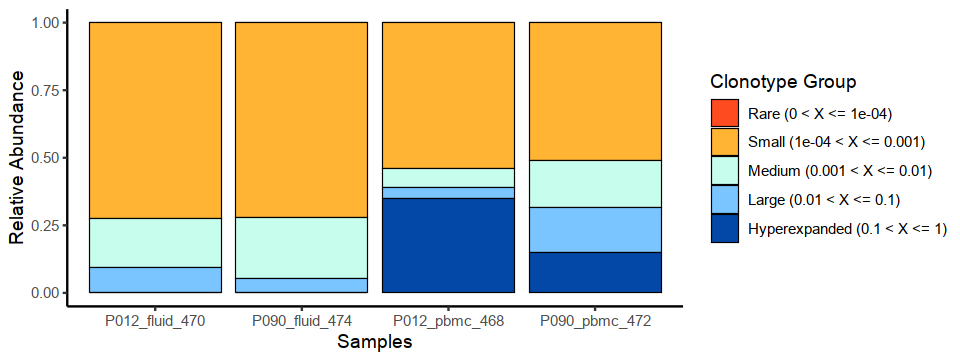

In [51]:
# Clonal space homeostasis
# cloneType variable in the function and can be adjusted, at baseline the bins are as follows:

# cloneTypes
# * Rare = .0001
# * Small = .001
# * Medium = .01
# * Large = .1
# * Hyperexpanded = 1

options(repr.plot.height = 3, repr.plot.width = 4)
clonalHomeostasis(combined, cloneCall = "gene", exportTable = TRUE)
clonalHomeostasis(combined, cloneCall = "gene", exportTable = FALSE)

options(repr.plot.height = 3, repr.plot.width = 8)
clonalHomeostasis(combined, cloneCall = "gene", exportTable = FALSE)

,Rare (0 < X <= 1e-04),Small (1e-04 < X <= 0.001),Medium (0.001 < X <= 0.01),Large (0.01 < X <= 0.1),Hyperexpanded (0.1 < X <= 1)
P012_fluid_470,0,0.7600324,0.1467369,0.09323064,0.0000000
P090_fluid_474,0,0.7381058,0.2232103,0.03868386,0.0000000
P012_pbmc_468,0,0.5412933,0.0687573,0.04031944,0.3496299
P090_pbmc_472,0,0.5174129,0.1778146,0.15699281,0.1477796


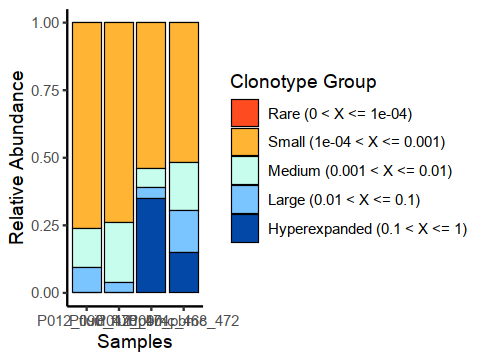

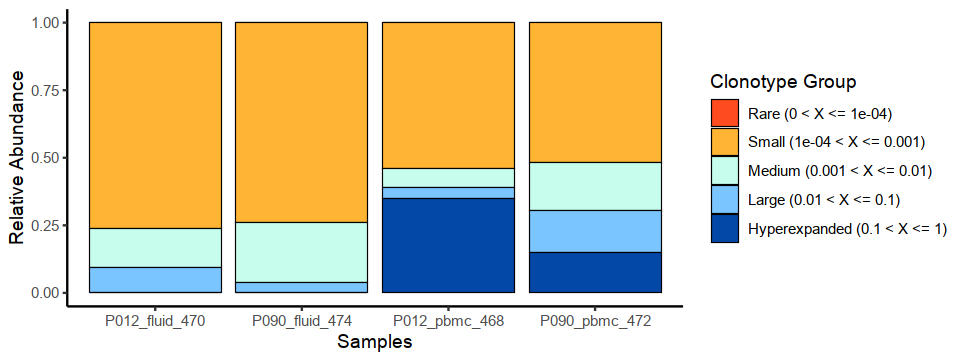

In [52]:
options(repr.plot.height = 3, repr.plot.width = 4)
clonalHomeostasis(combined, cloneCall = "aa", exportTable = TRUE)
clonalHomeostasis(combined, cloneCall = "aa", exportTable = FALSE)

options(repr.plot.height = 3, repr.plot.width = 8)
clonalHomeostasis(combined, cloneCall = "aa", exportTable = FALSE)

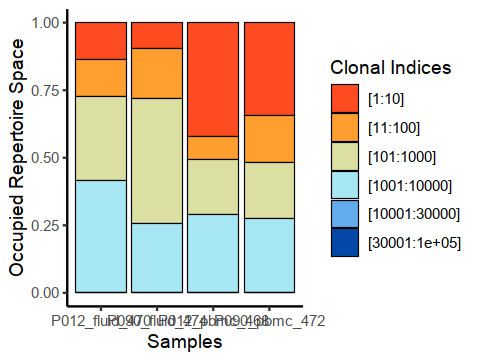

In [54]:
# Clone proportion
# Like clonal space homeostasis above, clonal proportion acts to place clones into separate bins. 
# The key difference is instead of looking at the relative proportion of the clone to the total, 
# the clonalProportion() function will rank the clones by total number and place them into bins.
# The split represents ranking of clonotypes by copy or frequency of occurrence, meaning 1:10 are the top 10 clonotypes in each sample.

options(repr.plot.height = 3, repr.plot.width = 4)
clonalProportion(combined, cloneCall = "gene") 

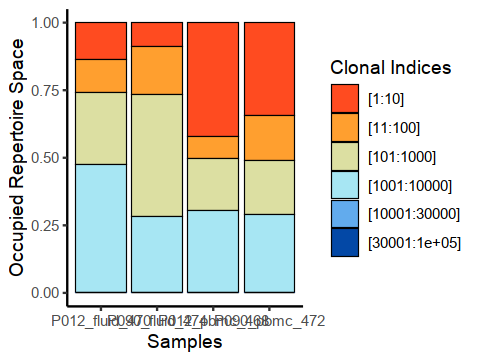

In [55]:
options(repr.plot.height = 3, repr.plot.width = 4)
clonalProportion(combined, cloneCall = "nt") 

Warning message:
“Removed 6 rows containing missing values (geom_text).”Warning message:
“Removed 6 rows containing missing values (geom_text).”

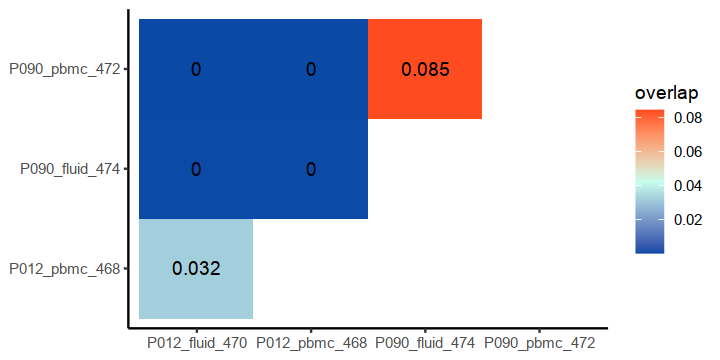

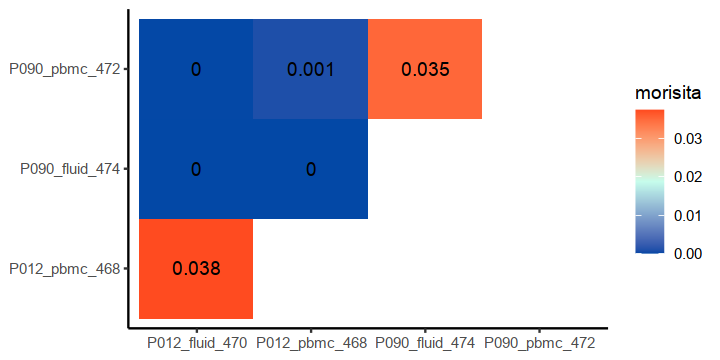

In [60]:
# Overlap analysis
# measures of similarity between the samples 


# 1. looking at the overlap of clonotypes scaled to the length of unique clonotypes in the smaller sample
options(repr.plot.height = 3, repr.plot.width = 6)
clonalOverlap(combined, cloneCall = "gene+nt", method = "overlap")

# 2. The Morisita index is more complex, it is an ecological measure of the dispersion of individuals within a population, incorporating the size of the population.
clonalOverlap(combined, cloneCall = "gene+nt", method = "morisita")

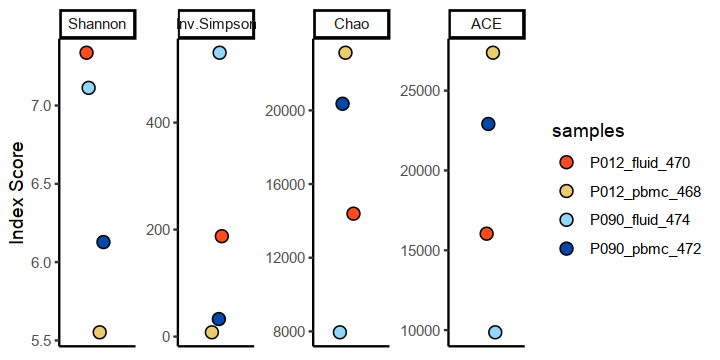

In [61]:
# Diversity Analysis
# Diversity is calculated using four metrics: 1) Shannon, 2) inverse Simpson, 3) Chao1, and 4) Abundance-based Coverage Estimator (ACE). 
# With the former two generally used to estimate baseline diversity and Chao/ACE indices used to estimate the richness of the samples.

clonalDiversity(combined, cloneCall = "gene", group = "samples")

In [25]:
# matching contig cell barcodes and barcodes
combined$P012_fluid_470[1:4,]
combined$P012_pbmc_468[1:4,1:4]
combined$P090_fluid_474[1:4,1:4]
combined$P090_pbmc_472[1:4,1:4]

,barcode,sample,ID,TCR1,cdr3_aa1,cdr3_nt1,TCR2,cdr3_aa2,cdr3_nt2,CTgene,CTnt,CTaa,CTstrict,cellType
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,P012_fluid_470_AAACCTGAGTAACCCT-1,P012,fluid_470,TRAV12-2.TRAJ44.TRAC,CAVFLPTGTASKLTF,TGTGCCGTGTTCTTACCTACCGGCACTGCCAGTAAACTCACCTTT,TRBV5-1.TRBJ2-1.None.TRBC2,CASSWTTDLNYNEQFF,TGCGCCAGCAGCTGGACGACAGACCTAAATTACAATGAGCAGTTCTTC,TRAV12-2.TRAJ44.TRAC_TRBV5-1.TRBJ2-1.None.TRBC2,TGTGCCGTGTTCTTACCTACCGGCACTGCCAGTAAACTCACCTTT_TGCGCCAGCAGCTGGACGACAGACCTAAATTACAATGAGCAGTTCTTC,CAVFLPTGTASKLTF_CASSWTTDLNYNEQFF,TRAV12-2.TRAJ44.TRAC_TGTGCCGTGTTCTTACCTACCGGCACTGCCAGTAAACTCACCTTT_TRBV5-1.TRBJ2-1.None.TRBC2_TGCGCCAGCAGCTGGACGACAGACCTAAATTACAATGAGCAGTTCTTC,T-AB
3,P012_fluid_470_AAACCTGCAGTTCCCT-1,P012,fluid_470,TRAV29/DV5.TRAJ42.TRAC,CAASAEGGSQGNLIF,TGTGCAGCAAGCGCGGAGGGAGGAAGCCAAGGAAATCTCATCTTT,TRBV5-4.TRBJ1-2.None.TRBC1,CASSPWTGGYGYTF,TGTGCCAGCAGCCCCTGGACAGGCGGGTATGGCTACACCTTC,TRAV29/DV5.TRAJ42.TRAC_TRBV5-4.TRBJ1-2.None.TRBC1,TGTGCAGCAAGCGCGGAGGGAGGAAGCCAAGGAAATCTCATCTTT_TGTGCCAGCAGCCCCTGGACAGGCGGGTATGGCTACACCTTC,CAASAEGGSQGNLIF_CASSPWTGGYGYTF,TRAV29/DV5.TRAJ42.TRAC_TGTGCAGCAAGCGCGGAGGGAGGAAGCCAAGGAAATCTCATCTTT_TRBV5-4.TRBJ1-2.None.TRBC1_TGTGCCAGCAGCCCCTGGACAGGCGGGTATGGCTACACCTTC,T-AB
5,P012_fluid_470_AAACCTGCATACTCTT-1,P012,fluid_470,TRAV5.TRAJ49.TRAC,CAESNTGNQFYF,TGTGCAGAGAGTAACACCGGTAACCAGTTCTATTTT,TRBV4-2.TRBJ2-2.None.TRBC2,CASSQDLLTGELFF,TGTGCCAGCAGCCAAGATCTGCTAACCGGGGAGCTGTTTTTT,TRAV5.TRAJ49.TRAC_TRBV4-2.TRBJ2-2.None.TRBC2,TGTGCAGAGAGTAACACCGGTAACCAGTTCTATTTT_TGTGCCAGCAGCCAAGATCTGCTAACCGGGGAGCTGTTTTTT,CAESNTGNQFYF_CASSQDLLTGELFF,TRAV5.TRAJ49.TRAC_TGTGCAGAGAGTAACACCGGTAACCAGTTCTATTTT_TRBV4-2.TRBJ2-2.None.TRBC2_TGTGCCAGCAGCCAAGATCTGCTAACCGGGGAGCTGTTTTTT,T-AB
7,P012_fluid_470_AAACCTGGTTATCGGT-1,P012,fluid_470,TRAV12-2.TRAJ52.TRAC;TRAV27.TRAJ28.TRAC,CAVNAGGTSYGKLTF;CAGDSYSGAGSYQLTF,TGTGCCGTCAATGCTGGTGGTACTAGCTATGGAAAGCTGACATTT;TGTGCAGGGGATTCATACTCTGGGGCTGGGAGTTACCAACTCACTTTC,NA,NA,NA,TRAV12-2.TRAJ52.TRAC;TRAV27.TRAJ28.TRAC_NA,TGTGCCGTCAATGCTGGTGGTACTAGCTATGGAAAGCTGACATTT;TGTGCAGGGGATTCATACTCTGGGGCTGGGAGTTACCAACTCACTTTC_NA,CAVNAGGTSYGKLTF;CAGDSYSGAGSYQLTF_NA,TRAV12-2.TRAJ52.TRAC;TRAV27.TRAJ28.TRAC_TGTGCCGTCAATGCTGGTGGTACTAGCTATGGAAAGCTGACATTT;TGTGCAGGGGATTCATACTCTGGGGCTGGGAGTTACCAACTCACTTTC_NA_NA,T-AB


,barcode,sample,ID,TCR1
,<chr>,<chr>,<chr>,<chr>
1,P012_pbmc_468_AAACCTGAGAACAACT-1,P012,pbmc_468,TRAV13-1.TRAJ49.TRAC
3,P012_pbmc_468_AAACCTGAGATCCCAT-1,P012,pbmc_468,TRAV17.TRAJ40.TRAC
5,P012_pbmc_468_AAACCTGAGGCCATAG-1,P012,pbmc_468,TRAV13-1.TRAJ49.TRAC
7,P012_pbmc_468_AAACCTGAGTCGCCGT-1,P012,pbmc_468,TRAV13-1.TRAJ49.TRAC


,barcode,sample,ID,TCR1
,<chr>,<chr>,<chr>,<chr>
1,P090_fluid_474_AAACCTGAGCAGGCTA-1,P090,fluid_474,TRAV14/DV4.TRAJ43.TRAC
3,P090_fluid_474_AAACCTGCAAACGCGA-1,P090,fluid_474,TRAV1-2.TRAJ31.TRAC
5,P090_fluid_474_AAACCTGCAACGATGG-1,P090,fluid_474,TRAV13-1.TRAJ3.TRAC
7,P090_fluid_474_AAACGGGCAAGTAGTA-1,P090,fluid_474,TRAV21.TRAJ6.TRAC


,barcode,sample,ID,TCR1
,<chr>,<chr>,<chr>,<chr>
1,P090_pbmc_472_AAACCTGAGACTGGGT-1,P090,pbmc_472,TRAV13-1.TRAJ47.TRAC;TRAV16.TRAJ43.TRAC
4,P090_pbmc_472_AAACCTGAGGCAAAGA-1,P090,pbmc_472,TRAV8-6.TRAJ53.TRAC
6,P090_pbmc_472_AAACCTGCATGGTTGT-1,P090,pbmc_472,TRAV13-1.TRAJ21.TRAC
8,P090_pbmc_472_AAACCTGCATTACCTT-1,P090,pbmc_472,TRAV12-1.TRAJ26.TRAC


In [ ]:
# In order to highlight the clonotypes, we first need to use the cloneCall the type of sequence we will be using and 
# then the specific sequences themselves using sequence. Below you can see the steps to highlight the two most prominent sequences
# "CAVNGGSQGNLIF_CSAEREDTDTQYF" with a frequency = 482 (clonotype 1) and "NA_CATSATLRVVAEKLFF" with a frequency = 287 (Clonotype2).

In [126]:
"CAFLGGGGNKLTF" %in% combined$P012_fluid_470$cdr3_aa1
combined$P012_fluid_470[which(combined$P012_fluid_470$cdr3_aa1 == "CAFLGGGGNKLTF"),]$CTaa

[1] TRUE

[1] "CAFLGGGGNKLTF_CASSPPVQGRDTIYF" "CAFLGGGGNKLTF_CASSPPVQGRDTIYF"
 [3] "CAFLGGGGNKLTF_CASSPPVQGRDTIYF" "CAFLGGGGNKLTF_CASSPPVQGRDTIYF"
 [5] "CAFLGGGGNKLTF_CASSPPVQGRDTIYF" "CAFLGGGGNKLTF_CASSPPVQGRDTIYF"
 [7] "CAFLGGGGNKLTF_CASSPPVQGRDTIYF" "CAFLGGGGNKLTF_NA"             
 [9] "CAFLGGGGNKLTF_CASSPPVQGRDTIYF" "CAFLGGGGNKLTF_CASSPPVQGRDTIYF"
[11] "CAFLGGGGNKLTF_CASSPPVQGRDTIYF" "CAFLGGGGNKLTF_CASSPPVQGRDTIYF"
[13] "CAFLGGGGNKLTF_CASSPPVQGRDTIYF" "CAFLGGGGNKLTF_CASSPPVQGRDTIYF"
[15] "CAFLGGGGNKLTF_CASSPPVQGRDTIYF" "CAFLGGGGNKLTF_CASSPPVQGRDTIYF"
[17] "CAFLGGGGNKLTF_CASSPPVQGRDTIYF" "CAFLGGGGNKLTF_CASSPPVQGRDTIYF"
[19] "CAFLGGGGNKLTF_CASSYIRGMGYEQYF" "CAFLGGGGNKLTF_CASSPPVQGRDTIYF"
[21] "CAFLGGGGNKLTF_CASSPPVQGRDTIYF" "CAFLGGGGNKLTF_CASSPPVQGRDTIYF"
[23] "CAFLGGGGNKLTF_CASSPPVQGRDTIYF" "CAFLGGGGNKLTF_CASSPPVQGRDTIYF"
[25] "CAFLGGGGNKLTF_CASSPPVQGRDTIYF" "CAFLGGGGNKLTF_CASSPPVQGRDTIYF"
[27] "CAFLGGGGNKLTF_CASSPPVQGRDTIYF" "CAFLGGGGNKLTF_CASSPPVQGRDTIYF"
[29] "CAFLGGGGNKLTF_CASSPPVQGRDTIYF" "CAFLGGGGNKLTF_CASSPPVQGRDTIYF"
[31] "CAFLGGGGNKLTF_CASSPPVQGRDTIYF" "CAFLGGGGNKLTF_CASSPPVQGRDTIYF"
[33] "CAFLGGGGNKLTF_CASSPPVQGRDTIYF" "CAFLGGGGNKLTF_CASSPPVQGRDTIYF"
[35] "CAFLGGGGNKLTF_CASSPPVQGRDTIYF" "CAFLGGGGNKLTF_NA"             
[37] "CAFLGGGGNKLTF_CASSPPVQGRDTIYF" "CAFLGGGGNKLTF_CASSPPVQGRDTIYF"
[39] "CAFLGGGGNKLTF_CASSPPVQGRDTIYF" "CAFLGGGGNKLTF_CASSPPVQGRDTIYF"
[41] "CAFLGGGGNKLTF_CASSPPVQGRDTIYF" "CAFLGGGGNKLTF_CASSPPVQGRDTIYF"

In [125]:
# Expanded clones in synovial fluid: (the same with the ones from Helena!)
# CAVFLPTGTASKLTF_CASSWTTDLNYNEQFF
# CVVFPGREYGNKLVF_CASSFREKVITGELFF
# CAFLGGGGNKLTF_CASSDPLATVPIYNEQFF

h_P012_fluid_470 <- combined$P012_fluid_470[which(combined$P012_fluid_470$CTaa %in% c(# "CAVFLPTGTASKLTF_CASSWTTDLNYNEQFF" 
#                                                                                      "CAPPETGFQKLVF_CASSQFETTGEAFF"
#                                                                                     "CAGGTSYGKLTF_CASSDPLATVPIYNEQFF"
#                                                                                     "CAGQVGGGSEKLVF_CASSPTGTGSRPQHF"
#                                                                                         "CAVQANTGNQFYF_CASSLVFREANTGELFF"
#                                                                                         "CVVFPGREYGNKLVF_CASSFREKVITGELFF"
#                                                                                         "CAFLGGGGNKLTF_CASSDPLATVPIYNEQFF"
#                                                                                      "CAASRGNQFYF_CASSYSSGYREQFF"
#                                                                                       "CANLYSGAGSYQLTF_CASSPFSGGTTYNEQFF", "CAGYSGAGSYQLTF_CASSVGDSQETQYF", "CAIYTGGFKTIF_CATSRDEGQDRDEQFF", "CAATEAKSSGDKLTF_CAWGSGTSGQGTQYF",
#                                                                                       "CAMTIGFGNVLHC_CASSLFPGGDDATNEKLFF", "CAYRSSPSNTGKLIF_CAWGSGTSGQGTQYF", "CAENIPGFQKLVF_CASRTGTDGYTF", "CAASSTSGYSTLTF_CASSVSWDSSYEQYF",
#                                                                                       "CAVYPGAGSYQLTF_CASSVSDSGETQYF",
    
#                                                                                     "CATESGGFKTIF_CASRGQEDEKLFF"
#                                                                                  "CAFLGGGGNKLTF_CASSPPVQGRDTIYP"
                                                                                    "CAFLGGGGNKLTF_CASSPPVQGRDTIYF"
                                                                                     )), ]

h_P012_pbmc_468 <- combined$P012_pbmc_468[which(combined$P012_pbmc_468$CTaa %in% c( # "CAVFLPTGTASKLTF_CASSWTTDLNYNEQFF" 
#                                                                                         "CVVFPGREYGNKLVF_CASSFREKVITGELFF"
#                                                                                     "CAFLGGGGNKLTF_CASSDPLATVPIYNEQFF"
#                                                                                   "CAPPETGFQKLVF_CASSQFETTGEAFF"
#                                                                                    "CAASRGNQFYF_CASSYSSGYREQFF"
#                                                                                      "CAGGTSYGKLTF_CASSDPLATVPIYNEQFF" 
#                                                                                      "CAGQVGGGSEKLVF_CASSPTGTGSRPQHF"
#                                                                                    "CAVQANTGNQFYF_CASSLVFREANTGELFF"
#                                                                                     "CAATEAKSSGDKLTF_CAWGSGTSGQGTQYF",
    
#                                                                                    "CATESGGFKTIF_CASRGQEDEKLFF"
#                                                                                         "CAFLGGGGNKLTF_CASSPPVQGRDTIYP"
#                                                                                    "CALSGGADGLTF_CASSLRGALPPQETQYF",
                                                                                        "CAFLGGGGNKLTF_CASSPPVQGRDTIYF"
                                                                                  )), ]
dim(h_P012_fluid_470)
dim(h_P012_pbmc_468)


# Expanded clones in the other synovial fluid: (the same with the ones from Helena!)
# CALSEGGSNFGNEKLTF_CAISDPRDSYEQYF
# CVVGGDSSYKLIF_CASRIPDTGELFF
# CAVPVYGGSQGNLIF_CASTYTTGVTGELFF

h_P090_fluid_474 <- combined$P090_fluid_474[which(combined$P090_fluid_474$CTaa %in% c(# "CALSEGGSNFGNEKLTF_CAISDPRDSYEQYF", 
#                                                                                        "CVVGGDSSYKLIF_CASRIPDTGELFF","CAVPVYGGSQGNLIF_CASTYTTGVTGELFF",
                                                                                      
#                                                                                       "CATDEDGGFKTIF_CAWLGGLLGTDTQYF", "CAFPSGTYKYIF_CASSPIAGGFNEQFF", "CAAYTGNMLTF_CATRQGSGDTQYF", "CAVRPFETGANNLFF_CASSQDGTQQAFF", "CAERRTDKLIF_CASSLELAGVMGSYNEQFF",
#                                                                                       "CAPGGGGYNKLIF_CAISQGENTEAFF", "CALQGSNDYKLSF_CASSTGQVTTNEKLFF", "CAASAGGGADGLTF_CASSQSLGLEQFF", "CAEAGNQFYF_CASSIDGTAYEQYF"
#                                                                                         "CATESGGFKTIF_CASRGQEDEKLFF"
                                                                                            "CAFLGGGGNKLTF_CASSPPVQGRDTIYP"
                                                                                     
                                                                                     )), ]

h_P090_pbmc_472 <- combined$P090_pbmc_472[which(combined$P090_pbmc_472$CTaa %in% c(# "CALSEGGSNFGNEKLTF_CAISDPRDSYEQYF", 
#                                                                                      "CVVGGDSSYKLIF_CASRIPDTGELFF", "CAVPVYGGSQGNLIF_CASTYTTGVTGELFF",
                                                                            
#                                                                                    "CVVPGNAGNMLTF_CASSAYNEQFF", "CAAPPYGGATNKLIF_CASSTSGIYEQYF", "CGTEIQYSGAGSYQLTF_CASSPFFSGASTDTQYF", "CAENTNSGTYKYIF_CATSLGGASNEQYF", "CAVNREDSNYQLIW_CASSTPADRATYEQYF",
#                                                                                    "CAMREGENSGGSNYKLTF_CATSREASTDTQYF", "CAMRAANTGNQFYF_CASSLNGAGANVLTF", "CILRDRVYDMRF_CASSYSLEREWDTQYF", "CALSEAWFGSGGSNYKLTF_CASSNRDLANYGYTF", "CAATPKKAAGNKLTF_CASSLELGGYTF",
#                                                                                    "CGADVSGTYKYIF_CASSPSVSYEQYF"
#                                                                                      "CATESGGFKTIF_CASRGQEDEKLFF"
                                                                                            "CAFLGGGGNKLTF_CASSPPVQGRDTIYP"
                                                                                  )), ]
dim(h_P090_fluid_474)
dim(h_P090_pbmc_472)

h_P090_fluid_474[1:4,]
h_P090_pbmc_472[1:4,]

[1] 39 14

[1] 21 14

[1]  0 14

[1]  0 14

,barcode,sample,ID,TCR1,cdr3_aa1,cdr3_nt1,TCR2,cdr3_aa2,cdr3_nt2,CTgene,CTnt,CTaa,CTstrict,cellType
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA.1,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA.2,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA.3,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


,barcode,sample,ID,TCR1,cdr3_aa1,cdr3_nt1,TCR2,cdr3_aa2,cdr3_nt2,CTgene,CTnt,CTaa,CTstrict,cellType
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA.1,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA.2,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA.3,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [127]:
h_P012_fluid_470$cell <- h_P012_fluid_470$barcode
h_P012_fluid_470$cell <- substring(h_P012_fluid_470$cell, 16)
h_P012_fluid_470$cell <- paste0("fluid_bri469", h_P012_fluid_470$cell, sep ="") # bri469 - bri470

h_P012_pbmc_468$cell <- h_P012_pbmc_468$barcode
h_P012_pbmc_468$cell <- substring(h_P012_pbmc_468$cell, 15)
h_P012_pbmc_468$cell <- paste0("pbmc_bri467", h_P012_pbmc_468$cell, sep ="") # bri467 - bri468

# h_P090_fluid_474$cell <- h_P090_fluid_474$barcode
# h_P090_fluid_474$cell <- substring(h_P090_fluid_474$cell, 16)
# h_P090_fluid_474$cell <- paste0("fluid_bri473", h_P090_fluid_474$cell, sep ="") # bri473 - bri474


# h_P090_pbmc_472$cell <- h_P090_pbmc_472$barcode
# h_P090_pbmc_472$cell <- substring(h_P090_pbmc_472$cell, 15)
# h_P090_pbmc_472$cell <- paste0("pbmc_bri471", h_P090_pbmc_472$cell, sep ="") # bri471 - bri472


In [68]:
# Load single-cell RNA-seq
meta_all <- readRDS("/data/srlab1/fzhang/results/2019_03_01_CD8_Brenner_data/2019_03_01_CD8_Brenner_data/meta_cd8_pure_helena_cd8_tis_bld_2021-02-01.rds")
dim(meta_all)
table(meta_all$sample)

[1] 9527   55


fluid_bri469 fluid_bri473  pbmc_bri467  pbmc_bri471 
        2206         1192         2700         3429 

In [31]:
set2 = c("#66C2A5", "#FC8D62", "#8DA0CB", "#E78AC3", "#A6D854", "#FFD92F", "#E5C494", "#B3B3B3")
set3 = c("#8DD3C7", "#FFFFB3", "#BEBADA", "#FB8072", "#80B1D3", "#FDB462", "#B3DE69", "#FCCDE5", "#D9D9D9", "#BC80BD", "#CCEBC5", "#FFED6F")
colors37 = c("#466791","#60bf37","#953ada","#4fbe6c","#ce49d3","#a7b43d","#5a51dc","#d49f36","#552095","#507f2d","#db37aa","#84b67c","#a06fda","#df462a","#5b83db","#c76c2d","#4f49a3","#82702d","#dd6bbb","#334c22","#d83979","#55baad","#dc4555","#62aad3","#8c3025","#417d61","#862977","#bba672","#403367","#da8a6d","#a79cd4","#71482c","#c689d0","#6b2940","#d593a7","#895c8b","#bd5975")

Warning message:
"`funs()` was deprecated in dplyr 0.8.0.
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated."


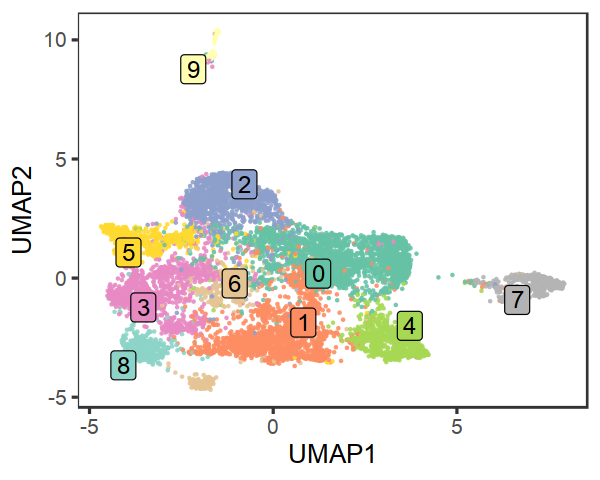

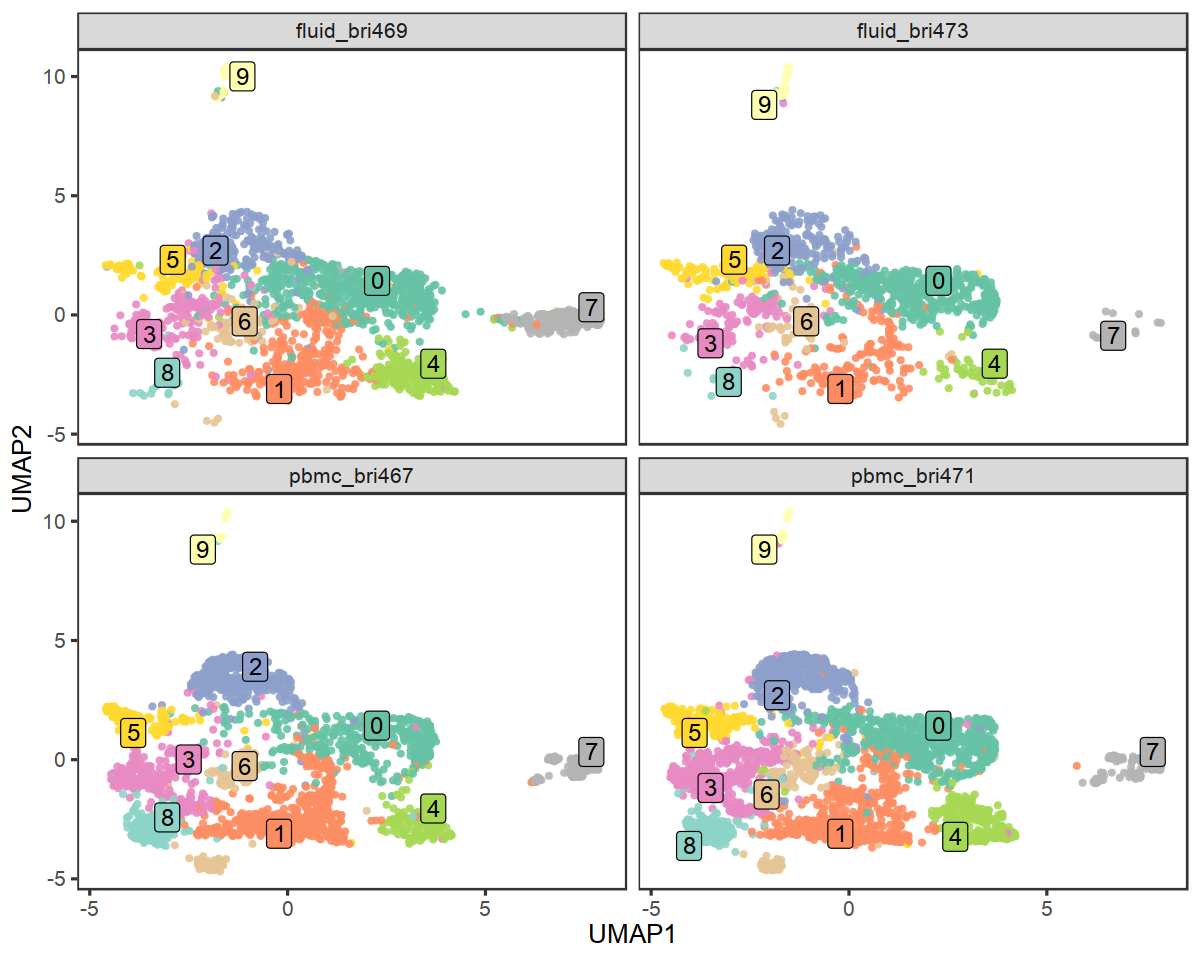

In [32]:
cluster_center <- meta_all %>%
                  group_by(res_0.40) %>%
                  summarise_at(vars(UMAP1, UMAP2), funs(median(., na.rm=TRUE)))
cluster_center <- as.data.frame(cluster_center)
cluster_center$res_0.40 <- as.character(cluster_center$res_0.40)

options(repr.plot.height = 4, repr.plot.width = 5)
ggplot(meta_all[sample(nrow(meta_all)),],
       aes(x = UMAP1, y = UMAP2, fill= res_0.40)
      ) +
  geom_point(size = 1, stroke = 0.0001, shape = 21, alpha = 0.9) +
  geom_label_repel(
    data = cluster_center,
    aes(label = res_0.40, fill = res_0.40),
#     fontface = 'bold', 
    size = 5, 
    box.padding = unit(0.2, "lines"),
    point.padding = unit(0.2, "lines"),
    segment.color = 'grey50'
  ) +
  scale_fill_manual(values = c(set2, set3), name = "") +
  labs(
      x = "UMAP1",
      y = "UMAP2"
      ) +
  theme_bw(base_size = 15) +
  theme(
    legend.position = "none",
#     axis.text = element_blank(),
#     axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", size=10, face = "italic")
)

options(repr.plot.height = 8, repr.plot.width = 10)
ggplot(meta_all[sample(nrow(meta_all)),],
       aes(x = UMAP1, y = UMAP2, fill= res_0.40)
      ) +
  geom_point(size = 2, stroke = 0.0001, shape = 21, alpha = 0.9) +
  geom_label_repel(
    data = cluster_center,
    aes(label = res_0.40, fill = res_0.40),
#     fontface = 'bold', 
    size = 5, 
    box.padding = unit(0.2, "lines"),
    point.padding = unit(0.2, "lines"),
    segment.color = 'grey50'
  ) +
  facet_wrap(sample ~., ncol = 2 ) +
  scale_fill_manual(values = c(set2, set3), name = "") +
  labs(
      x = "UMAP1",
      y = "UMAP2"
      ) +
  theme_bw(base_size = 15) +
  theme(
    legend.position = "none",
#     axis.text = element_blank(),
#     axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", size=10, face = "italic")
)

[1] 304

[1] 38

[1] 92

[1] 39


                   NO clones_P012_fluid_470  clones_P012_pbmc_468 
                 9054                   304                    92 
clones_P090_fluid_474  clones_P090_pbmc_472 
                   38                    39 

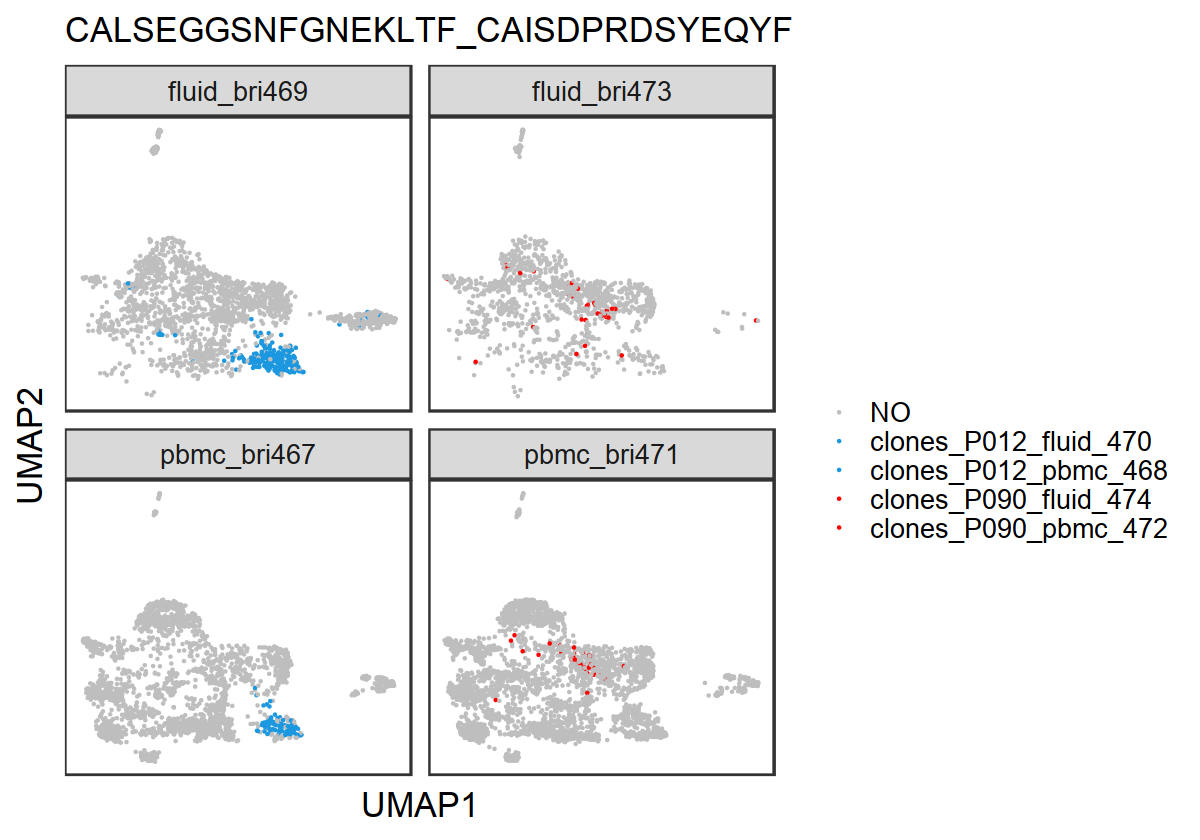

In [45]:
length(intersect(h_P012_fluid_470$cell, meta_all$cell))
length(intersect(h_P090_fluid_474$cell, meta_all$cell))
length(intersect(h_P012_pbmc_468$cell, meta_all$cell))
length(intersect(h_P090_pbmc_472$cell, meta_all$cell))

# Label the cells with expanded clones
meta_all$clone <- rep("NO", nrow(meta_all))
meta_all[which(meta_all$cell %in% h_P012_fluid_470$cell), ]$clone <- "clones_P012_fluid_470"
meta_all[which(meta_all$cell %in% h_P090_fluid_474$cell), ]$clone <- "clones_P090_fluid_474"
meta_all[which(meta_all$cell %in% h_P012_pbmc_468$cell), ]$clone <- "clones_P012_pbmc_468"
meta_all[which(meta_all$cell %in% h_P090_pbmc_472$cell), ]$clone <- "clones_P090_pbmc_472"
table(meta_all$clone)

this_clone <- "CALSEGGSNFGNEKLTF_CAISDPRDSYEQYF"
options(repr.plot.height = 7, repr.plot.width = 10)
ggplot() +
  geom_point(
    data = meta_all[sample(nrow(meta_all)),],
    mapping = aes_string(x = "UMAP1", y = "UMAP2", fill = "clone"),
    size = 1, stroke = 0.0001, shape = 21
  ) +
  scale_fill_manual(values = c("grey", "#1b98e0ff", "#1b98e0ff", "red", "red"), name = "") +
  labs(title = clone) +
  facet_wrap(sample ~., ncol = 2 ) +
  theme_bw(base_size = 20) +
  theme(
#     legend.position = "none",
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", size=20)
  ) 
ggsave(file = paste(this_clone, "_plot", ".pdf", sep = ""), width = 10, height = 7, dpi = 300)

[1] 68

[1] 0

[1] 24

[1] 0

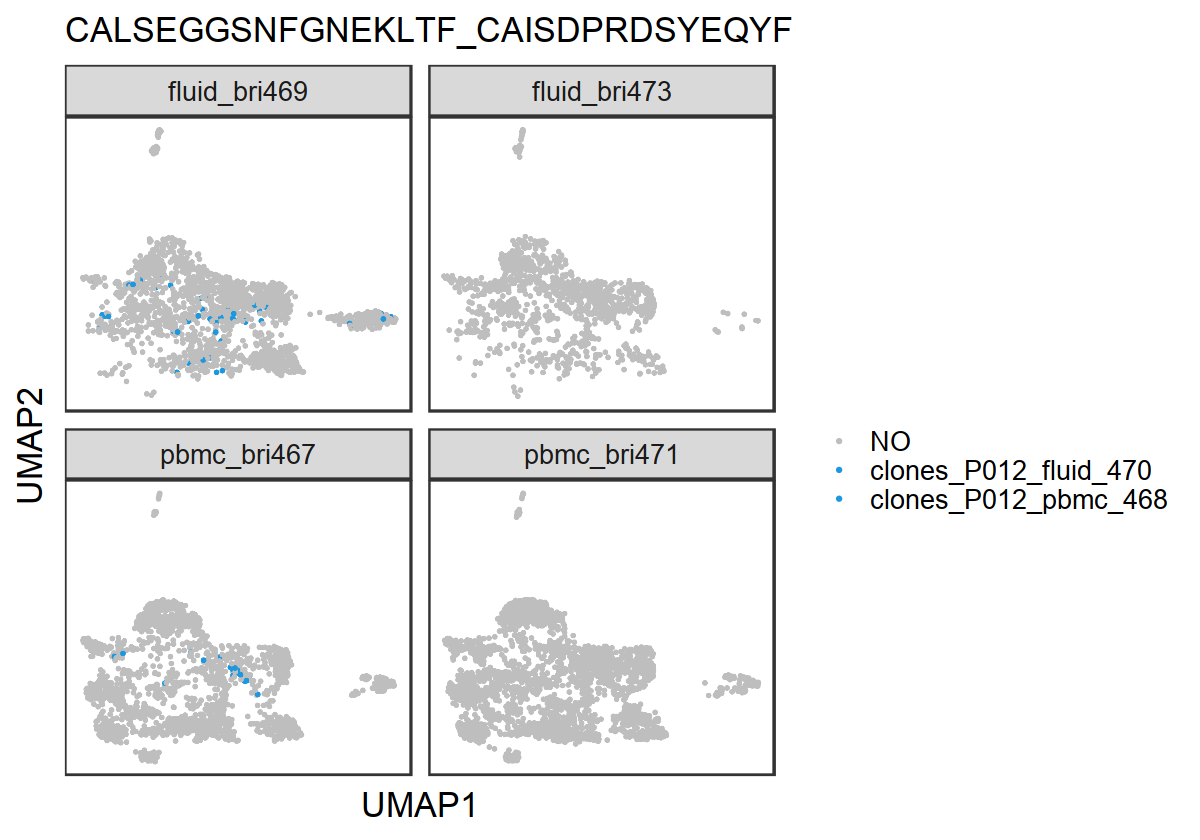

In [79]:
length(intersect(h_P012_fluid_470$cell, meta_all$cell))
length(intersect(h_P090_fluid_474$cell, meta_all$cell))
length(intersect(h_P012_pbmc_468$cell, meta_all$cell))
length(intersect(h_P090_pbmc_472$cell, meta_all$cell))

# Label the cells with expanded clones
meta_all$clone <- rep("NO", nrow(meta_all))
meta_all[which(meta_all$cell %in% h_P012_fluid_470$cell), ]$clone <- "clones_P012_fluid_470"
# meta_all[which(meta_all$cell %in% h_P090_fluid_474$cell), ]$clone <- "clones_P090_fluid_474"
meta_all[which(meta_all$cell %in% h_P012_pbmc_468$cell), ]$clone <- "clones_P012_pbmc_468"
# meta_all[which(meta_all$cell %in% h_P090_pbmc_472$cell), ]$clone <- "clones_P090_pbmc_472"
tab_save <- as.data.frame(table(meta_all$clone))
colnames(tab_save) <- c("type", "frequency")
write.table(tab_save, file = paste(this_clone, "_number", ".txt", sep = ""),
            row.names=T,col.names=T, quote = F, sep = "\t")


this_clone <- "CVVFPGREYGNKLVF_CASSFREKVITGELFF"
options(repr.plot.height = 7, repr.plot.width = 10)
ggplot() +
  geom_point_rast(
    data = meta_all[sample(nrow(meta_all)),],
    mapping = aes_string(x = "UMAP1", y = "UMAP2", fill = "clone"),
    size = 1.5, stroke = 0.0001, shape = 21
  ) +
  scale_fill_manual(values = c("grey", "#1b98e0ff", "#1b98e0ff", "red", "red"), name = "") +
  labs(title = clone) +
  facet_wrap(sample ~., ncol = 2 ) +
  theme_bw(base_size = 20) +
  theme(
#     legend.position = "none",
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", size=20)
  ) 
ggsave(file = paste(this_clone, "_plot", ".pdf", sep = ""), width = 10, height = 7, dpi = 300)



[1] 304

[1] 0

[1] 92

[1] 0

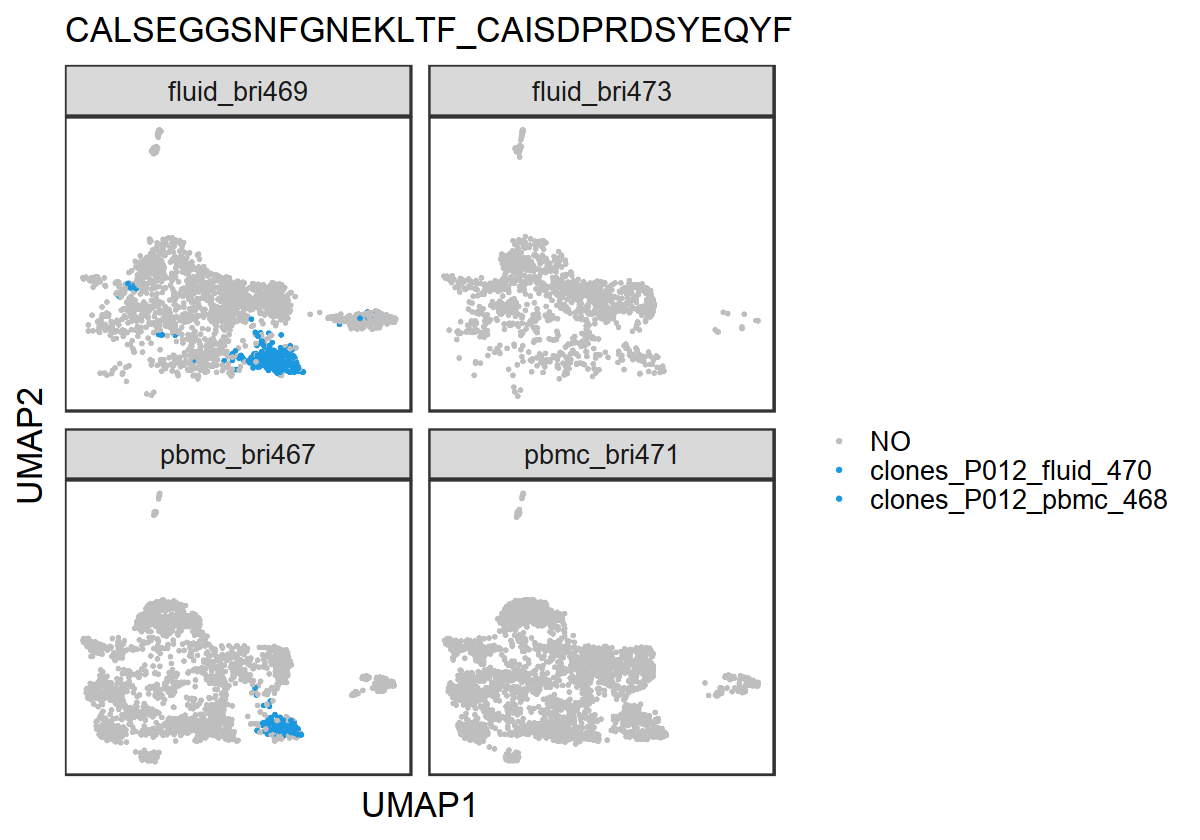

In [92]:

length(intersect(h_P012_fluid_470$cell, meta_all$cell))
length(intersect(h_P090_fluid_474$cell, meta_all$cell))
length(intersect(h_P012_pbmc_468$cell, meta_all$cell))
length(intersect(h_P090_pbmc_472$cell, meta_all$cell))

# Label the cells with expanded clones
meta_all$clone <- rep("NO", nrow(meta_all))
meta_all[which(meta_all$cell %in% h_P012_fluid_470$cell), ]$clone <- "clones_P012_fluid_470"
# meta_all[which(meta_all$cell %in% h_P090_fluid_474$cell), ]$clone <- "clones_P090_fluid_474"
meta_all[which(meta_all$cell %in% h_P012_pbmc_468$cell), ]$clone <- "clones_P012_pbmc_468"
# meta_all[which(meta_all$cell %in% h_P090_pbmc_472$cell), ]$clone <- "clones_P090_pbmc_472"
tab_save <- as.data.frame(table(meta_all$clone))
colnames(tab_save) <- c("type", "frequency")
write.table(tab_save, file = paste(this_clone, "_number", ".txt", sep = ""),
            row.names=T,col.names=T, quote = F, sep = "\t")


this_clone <-  "CAVFLPTGTASKLTF_CASSWTTDLNYNEQFF"
options(repr.plot.height = 7, repr.plot.width = 10)
ggplot() +
  geom_point_rast(
    data = meta_all[sample(nrow(meta_all)),],
    mapping = aes_string(x = "UMAP1", y = "UMAP2", fill = "clone"),
    size = 1.5, stroke = 0.0001, shape = 21
  ) +
  scale_fill_manual(values = c("grey", "#1b98e0ff", "#1b98e0ff", "red", "red"), name = "") +
  labs(title = clone) +
  facet_wrap(sample ~., ncol = 2 ) +
  theme_bw(base_size = 20) +
  theme(
#     legend.position = "none",
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", size=20)
  ) 
ggsave(file = paste(this_clone, "_plot", ".pdf", sep = ""), width = 10, height = 7, dpi = 300)




[1] 4

[1] 0

[1] 56

[1] 0

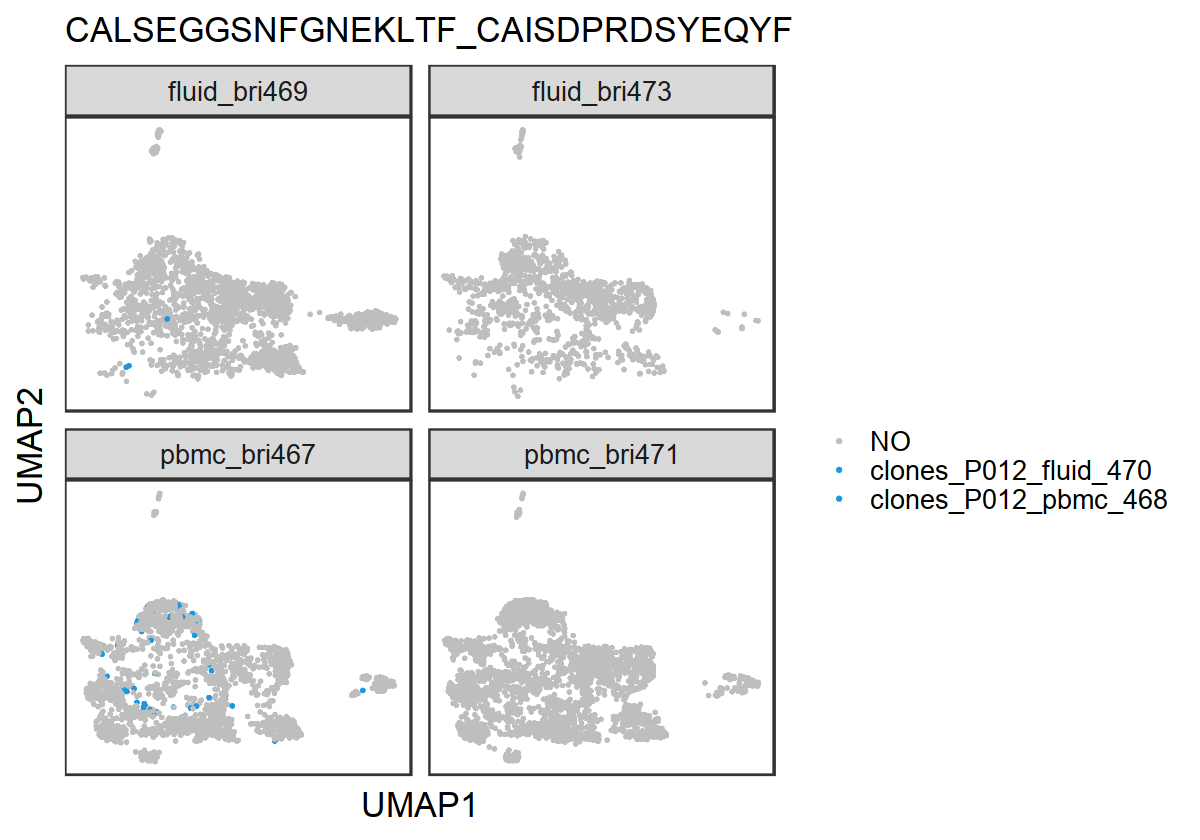

In [97]:

length(intersect(h_P012_fluid_470$cell, meta_all$cell))
length(intersect(h_P090_fluid_474$cell, meta_all$cell))
length(intersect(h_P012_pbmc_468$cell, meta_all$cell))
length(intersect(h_P090_pbmc_472$cell, meta_all$cell))

# Label the cells with expanded clones
meta_all$clone <- rep("NO", nrow(meta_all))
meta_all[which(meta_all$cell %in% h_P012_fluid_470$cell), ]$clone <- "clones_P012_fluid_470"
# meta_all[which(meta_all$cell %in% h_P090_fluid_474$cell), ]$clone <- "clones_P090_fluid_474"
meta_all[which(meta_all$cell %in% h_P012_pbmc_468$cell), ]$clone <- "clones_P012_pbmc_468"
# meta_all[which(meta_all$cell %in% h_P090_pbmc_472$cell), ]$clone <- "clones_P090_pbmc_472"
tab_save <- as.data.frame(table(meta_all$clone))
colnames(tab_save) <- c("type", "frequency")
write.table(tab_save, file = paste(this_clone, "_number", ".txt", sep = ""),
            row.names=T,col.names=T, quote = F, sep = "\t")


this_clone <-  "CAPPETGFQKLVF_CASSQFETTGEAFF"
options(repr.plot.height = 7, repr.plot.width = 10)
ggplot() +
  geom_point_rast(
    data = meta_all[sample(nrow(meta_all)),],
    mapping = aes_string(x = "UMAP1", y = "UMAP2", fill = "clone"),
    size = 1.5, stroke = 0.0001, shape = 21
  ) +
  scale_fill_manual(values = c("grey", "#1b98e0ff", "#1b98e0ff", "red", "red"), name = "") +
  labs(title = clone) +
  facet_wrap(sample ~., ncol = 2 ) +
  theme_bw(base_size = 20) +
  theme(
#     legend.position = "none",
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", size=20)
  ) 
ggsave(file = paste(this_clone, "_plot", ".pdf", sep = ""), width = 10, height = 7, dpi = 300)




[1] 8

[1] 0

[1] 35

[1] 0

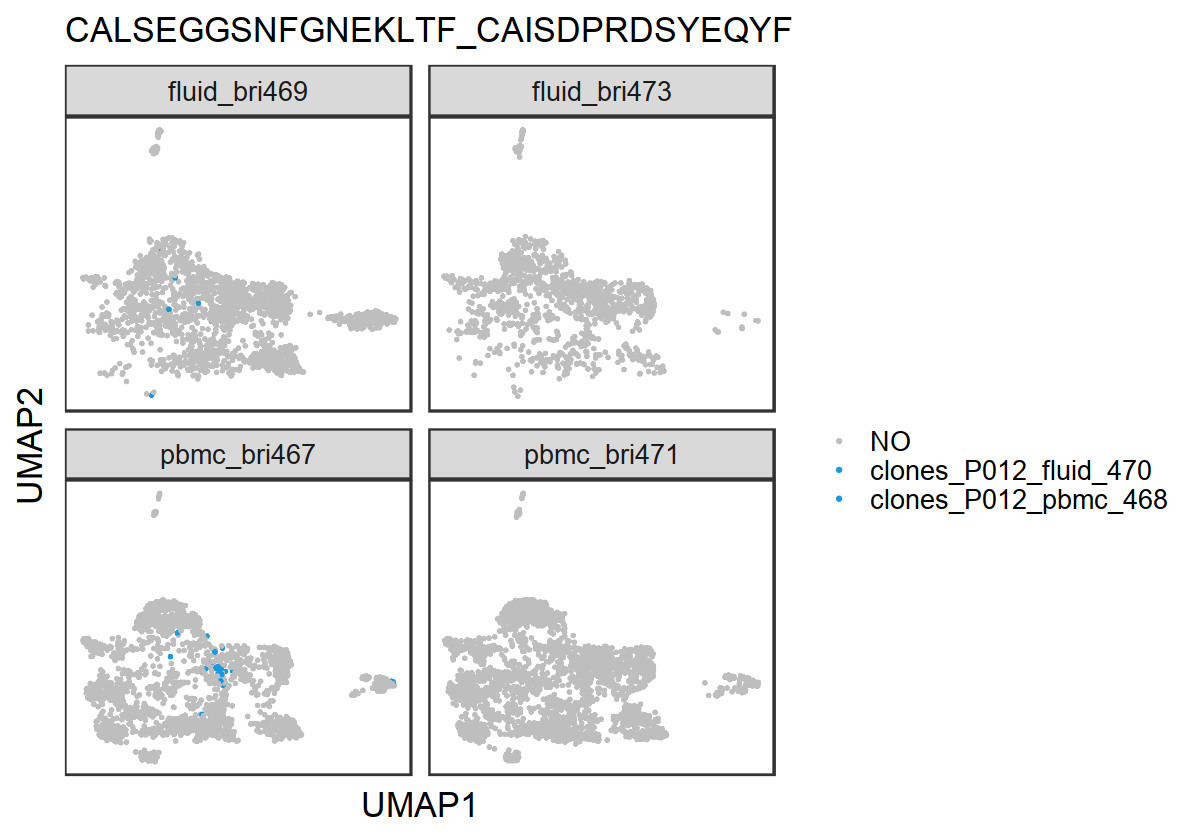

In [101]:

length(intersect(h_P012_fluid_470$cell, meta_all$cell))
length(intersect(h_P090_fluid_474$cell, meta_all$cell))
length(intersect(h_P012_pbmc_468$cell, meta_all$cell))
length(intersect(h_P090_pbmc_472$cell, meta_all$cell))

# Label the cells with expanded clones
meta_all$clone <- rep("NO", nrow(meta_all))
meta_all[which(meta_all$cell %in% h_P012_fluid_470$cell), ]$clone <- "clones_P012_fluid_470"
# meta_all[which(meta_all$cell %in% h_P090_fluid_474$cell), ]$clone <- "clones_P090_fluid_474"
meta_all[which(meta_all$cell %in% h_P012_pbmc_468$cell), ]$clone <- "clones_P012_pbmc_468"
# meta_all[which(meta_all$cell %in% h_P090_pbmc_472$cell), ]$clone <- "clones_P090_pbmc_472"
tab_save <- as.data.frame(table(meta_all$clone))
colnames(tab_save) <- c("type", "frequency")
write.table(tab_save, file = paste(this_clone, "_number", ".txt", sep = ""),
            row.names=T,col.names=T, quote = F, sep = "\t")


this_clone <-  "CAGGTSYGKLTF_CASSDPLATVPIYNEQFF"
options(repr.plot.height = 7, repr.plot.width = 10)
ggplot() +
  geom_point_rast(
    data = meta_all[sample(nrow(meta_all)),],
    mapping = aes_string(x = "UMAP1", y = "UMAP2", fill = "clone"),
    size = 1.5, stroke = 0.0001, shape = 21
  ) +
  scale_fill_manual(values = c("grey", "#1b98e0ff", "#1b98e0ff", "red", "red"), name = "") +
  labs(title = clone) +
  facet_wrap(sample ~., ncol = 2 ) +
  theme_bw(base_size = 20) +
  theme(
#     legend.position = "none",
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", size=20)
  ) 
ggsave(file = paste(this_clone, "_plot", ".pdf", sep = ""), width = 10, height = 7, dpi = 300)




[1] 4

[1] 0

[1] 23

[1] 0

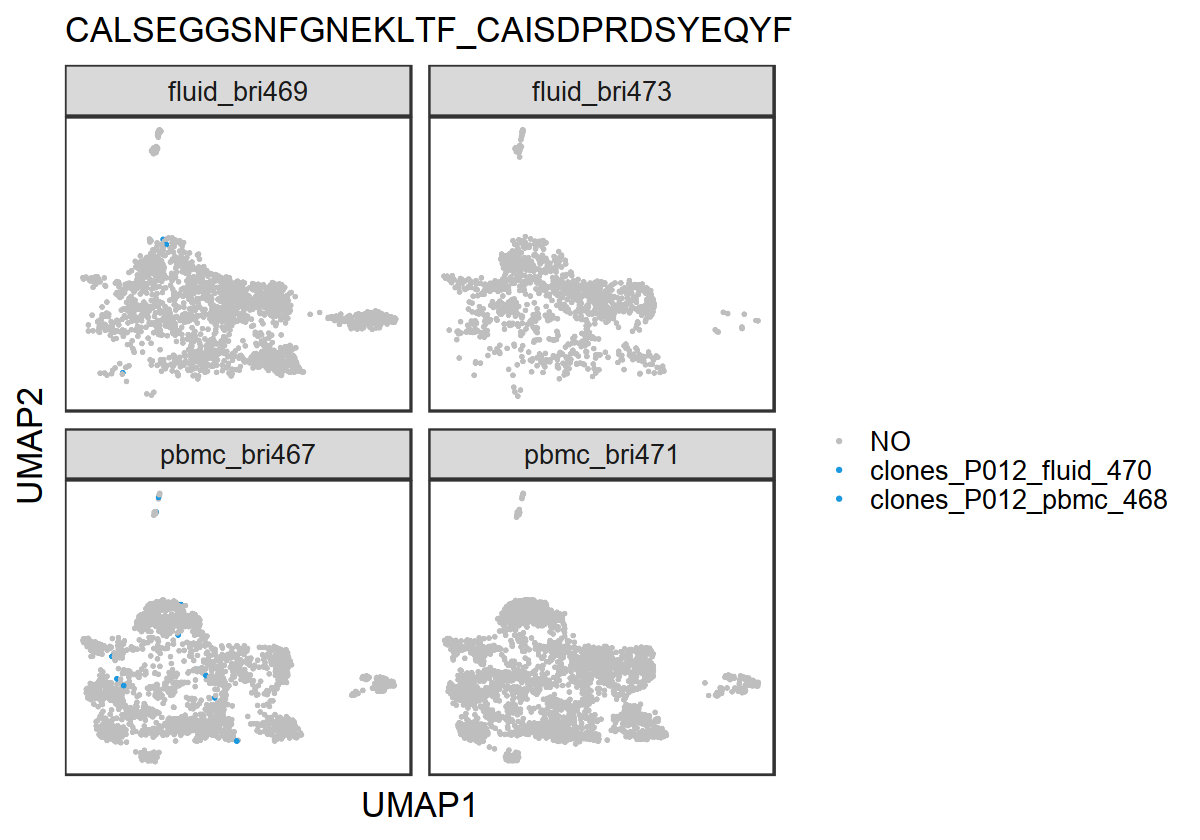

In [104]:

length(intersect(h_P012_fluid_470$cell, meta_all$cell))
length(intersect(h_P090_fluid_474$cell, meta_all$cell))
length(intersect(h_P012_pbmc_468$cell, meta_all$cell))
length(intersect(h_P090_pbmc_472$cell, meta_all$cell))

# Label the cells with expanded clones
meta_all$clone <- rep("NO", nrow(meta_all))
meta_all[which(meta_all$cell %in% h_P012_fluid_470$cell), ]$clone <- "clones_P012_fluid_470"
# meta_all[which(meta_all$cell %in% h_P090_fluid_474$cell), ]$clone <- "clones_P090_fluid_474"
meta_all[which(meta_all$cell %in% h_P012_pbmc_468$cell), ]$clone <- "clones_P012_pbmc_468"
# meta_all[which(meta_all$cell %in% h_P090_pbmc_472$cell), ]$clone <- "clones_P090_pbmc_472"
tab_save <- as.data.frame(table(meta_all$clone))
colnames(tab_save) <- c("type", "frequency")
write.table(tab_save, file = paste(this_clone, "_number", ".txt", sep = ""),
            row.names=T,col.names=T, quote = F, sep = "\t")


this_clone <-  "CAGQVGGGSEKLVF_CASSPTGTGSRPQHF"
options(repr.plot.height = 7, repr.plot.width = 10)
ggplot() +
  geom_point_rast(
    data = meta_all[sample(nrow(meta_all)),],
    mapping = aes_string(x = "UMAP1", y = "UMAP2", fill = "clone"),
    size = 1.5, stroke = 0.0001, shape = 21
  ) +
  scale_fill_manual(values = c("grey", "#1b98e0ff", "#1b98e0ff", "red", "red"), name = "") +
  labs(title = clone) +
  facet_wrap(sample ~., ncol = 2 ) +
  theme_bw(base_size = 20) +
  theme(
#     legend.position = "none",
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", size=20)
  ) 
ggsave(file = paste(this_clone, "_plot", ".pdf", sep = ""), width = 10, height = 7, dpi = 300)




[1] 7

[1] 0

[1] 9

[1] 0

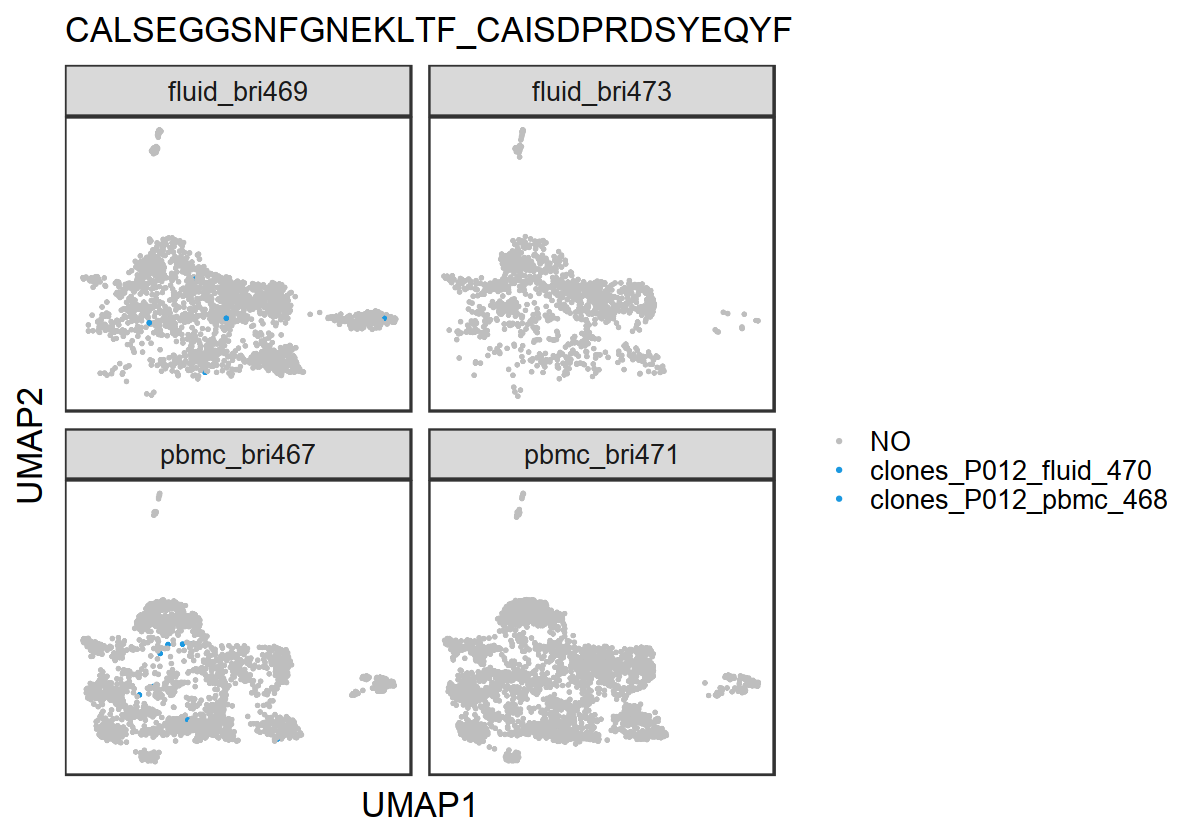

In [107]:

length(intersect(h_P012_fluid_470$cell, meta_all$cell))
length(intersect(h_P090_fluid_474$cell, meta_all$cell))
length(intersect(h_P012_pbmc_468$cell, meta_all$cell))
length(intersect(h_P090_pbmc_472$cell, meta_all$cell))

# Label the cells with expanded clones
meta_all$clone <- rep("NO", nrow(meta_all))
meta_all[which(meta_all$cell %in% h_P012_fluid_470$cell), ]$clone <- "clones_P012_fluid_470"
# meta_all[which(meta_all$cell %in% h_P090_fluid_474$cell), ]$clone <- "clones_P090_fluid_474"
meta_all[which(meta_all$cell %in% h_P012_pbmc_468$cell), ]$clone <- "clones_P012_pbmc_468"
# meta_all[which(meta_all$cell %in% h_P090_pbmc_472$cell), ]$clone <- "clones_P090_pbmc_472"
tab_save <- as.data.frame(table(meta_all$clone))
colnames(tab_save) <- c("type", "frequency")
write.table(tab_save, file = paste(this_clone, "_number", ".txt", sep = ""),
            row.names=T,col.names=T, quote = F, sep = "\t")


this_clone <-  "CAVQANTGNQFYF_CASSLVFREANTGELFF"
options(repr.plot.height = 7, repr.plot.width = 10)
ggplot() +
  geom_point_rast(
    data = meta_all[sample(nrow(meta_all)),],
    mapping = aes_string(x = "UMAP1", y = "UMAP2", fill = "clone"),
    size = 1.5, stroke = 0.0001, shape = 21
  ) +
  scale_fill_manual(values = c("grey", "#1b98e0ff", "#1b98e0ff", "red", "red"), name = "") +
  labs(title = clone) +
  facet_wrap(sample ~., ncol = 2 ) +
  theme_bw(base_size = 20) +
  theme(
#     legend.position = "none",
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", size=20)
  ) 
ggsave(file = paste(this_clone, "_plot", ".pdf", sep = ""), width = 10, height = 7, dpi = 300)




[1] 35

[1] 0

[1] 20

[1] 0

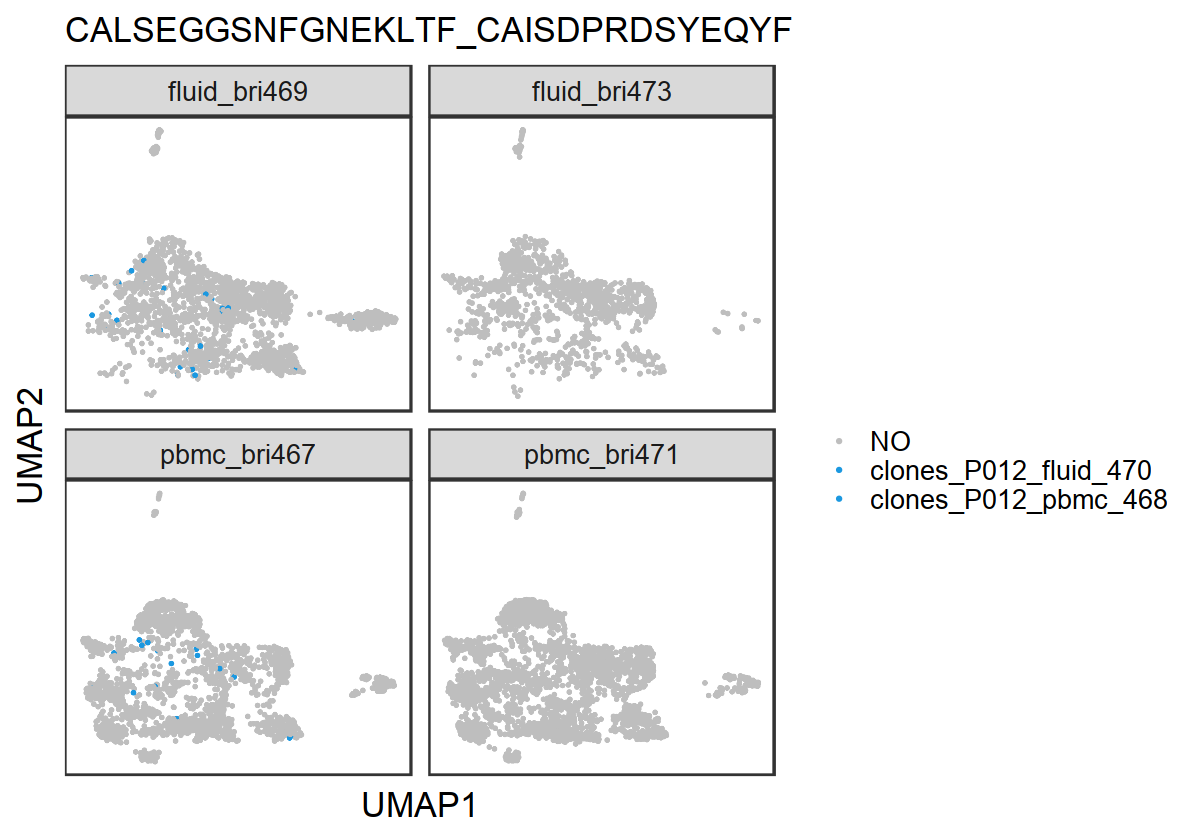

In [128]:

length(intersect(h_P012_fluid_470$cell, meta_all$cell))
length(intersect(h_P090_fluid_474$cell, meta_all$cell))
length(intersect(h_P012_pbmc_468$cell, meta_all$cell))
length(intersect(h_P090_pbmc_472$cell, meta_all$cell))

# Label the cells with expanded clones
meta_all$clone <- rep("NO", nrow(meta_all))
meta_all[which(meta_all$cell %in% h_P012_fluid_470$cell), ]$clone <- "clones_P012_fluid_470"
# meta_all[which(meta_all$cell %in% h_P090_fluid_474$cell), ]$clone <- "clones_P090_fluid_474"
meta_all[which(meta_all$cell %in% h_P012_pbmc_468$cell), ]$clone <- "clones_P012_pbmc_468"
# meta_all[which(meta_all$cell %in% h_P090_pbmc_472$cell), ]$clone <- "clones_P090_pbmc_472"
tab_save <- as.data.frame(table(meta_all$clone))
colnames(tab_save) <- c("type", "frequency")
write.table(tab_save, file = paste(this_clone, "_number", ".txt", sep = ""),
            row.names=T,col.names=T, quote = F, sep = "\t")


this_clone <-  "CAFLGGGGNKLTF_CASSPPVQGRDTIYF"
options(repr.plot.height = 7, repr.plot.width = 10)
ggplot() +
  geom_point_rast(
    data = meta_all[sample(nrow(meta_all)),],
    mapping = aes_string(x = "UMAP1", y = "UMAP2", fill = "clone"),
    size = 1.5, stroke = 0.0001, shape = 21
  ) +
  scale_fill_manual(values = c("grey", "#1b98e0ff", "#1b98e0ff", "red", "red"), name = "") +
  labs(title = clone) +
  facet_wrap(sample ~., ncol = 2 ) +
  theme_bw(base_size = 20) +
  theme(
#     legend.position = "none",
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", size=20)
  ) 
ggsave(file = paste(this_clone, "_plot", ".pdf", sep = ""), width = 10, height = 7, dpi = 300)




In [62]:
library(ggrastr)

In [131]:
# Add clones to the embeddings
dim(meta_all)
rm(meta_all_clone)
meta_all_clone <- merge(x = meta_all, y = h_P012_fluid_470[, c("cell", "CTaa")], by = "cell", all.x = TRUE)
meta_all_clone <- merge(x = meta_all_clone, y = h_P090_fluid_474[, c("cell", "CTaa")], by = "cell", all.x = TRUE)
meta_all_clone <- merge(x = meta_all_clone, y = h_P012_pbmc_468[, c("cell", "CTaa")], by = "cell", all.x = TRUE)
meta_all_clone <- merge(x = meta_all_clone, y = h_P090_pbmc_472[, c("cell", "CTaa")], by = "cell", all.x = TRUE)
dim(meta_all_clone)

[1] 9527   56

Warning message in merge.data.frame(x = meta_all_clone, y = h_P090_pbmc_472[, c("cell", :
“column names ‘CTaa.x’, ‘CTaa.y’ are duplicated in the result”


[1] 9527   60

In [132]:
# meta_all_clone[which(meta_all_clone$clone == "clones_P012_fluid_470"),][1:4,]
# meta_all_clone[which(meta_all_clone$clone == "clones_P090_fluid_474"),][1:4,]
# meta_all_clone[which(meta_all_clone$clone == "clones_P012_pbmc_468"),][1:4,]
# meta_all_clone[which(meta_all_clone$clone == "clones_P090_pbmc_472"),][1:4,]

meta_all_clone$CTaa <- paste5(meta_all_clone[, c(57:ncol(meta_all_clone))], na.rm = TRUE) 
meta_all_clone[1:4,]
dim(meta_all_clone)

,cell,sample,patient,tissue,nUMI,nGene,percent_mito,PC1,PC2,PC3,⋯,res_0.80,gene,DDRTree1,DDRTree2,clone,CTaa.x,CTaa.y,CTaa.x.1,CTaa.y.1,CTaa
,<chr>,<chr>,<fct>,<fct>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,fluid_bri469AAACCTGAGTAACCCT-1,fluid_bri469,PO12,fluid,4515,1805,0.05049834,6.256281,-5.3792723,-0.5455915,⋯,5,0,2.9310097,-0.582281,clones_P012_fluid_470,CAVFLPTGTASKLTF_CASSWTTDLNYNEQFF,NA,NA,NA,CAVFLPTGTASKLTF_CASSWTTDLNYNEQFF
2,fluid_bri469AAACCTGCAGTTCCCT-1,fluid_bri469,PO12,fluid,4198,1597,0.04359219,11.892749,-0.9593356,-2.3825863,⋯,1,0,3.6959261,-2.715905,NO,NA,NA,NA,NA,NA
3,fluid_bri469AAACCTGCATACTCTT-1,fluid_bri469,PO12,fluid,6300,2277,0.06539683,10.420466,-0.9569161,-4.4248248,⋯,6,0,0.8252643,-1.298348,NO,NA,NA,NA,NA,NA
4,fluid_bri469AAACCTGTCGGCGGTT-1,fluid_bri469,PO12,fluid,4704,1699,0.03677721,12.292716,-0.3168623,-2.5032397,⋯,7,0,-1.9182248,-1.717677,NO,NA,NA,NA,NA,NA


[1] 9527   61

In [134]:
# saveRDS(meta_all_clone, "meta_all_clonefromHelena_2021-09-08.rds")

In [133]:
table(meta_all_clone$CTaa, meta_all_clone$res_0.40)
table(meta_all_clone$clone, meta_all_clone$res_0.40)

                                     
                                        0   1   2   3   4   5   6   7   8   9
  CAAPPYGGATNKLIF_CASSTSGIYEQYF         0   3   0   2 128   4   0   0   0   1
  CAASAGGGADGLTF_CASSQSLGLEQFF          5   2   2   1   0   1   0   0   0   0
  CAASRGNQFYF_CASSYSSGYREQFF           19 505 332 256   0  91 195 110 245  11
  CAASSTSGYSTLTF_CASSVSWDSSYEQYF        4   4   3   2   0   3   0   2   0   0
  CAATPKKAAGNKLTF_CASSLELGGYTF          0   0  31   1   0   0   0   0   0   0
  CAAYTGNMLTF_CATRQGSGDTQYF             1   2   6   0   1   4   2   0   1   1
  CAEAGNQFYF_CASSIDGTAYEQYF             0   2   0   1   0   0   1   0   0   0
  CAENIPGFQKLVF_CASRTGTDGYTF            5   4   0   3   0   0   1   5   0   1
  CAENTNSGTYKYIF_CATSLGGASNEQYF         7  20   0  15  16   6   9   8   3   0
  CAERRTDKLIF_CASSLELAGVMGSYNEQFF       3   3   2   2   0   3   1   0   0   0
  CAFPSGTYKYIF_CASSPIAGGFNEQFF          2   4   7   1   0   2   2   0   0   0
  CAGGTSYGKLTF_CASSDPLATVP

                       
                           0    1    2    3    4    5    6    7    8    9
  clones_P012_fluid_470   61   55   27   17  254   26   20   31    0   15
  clones_P012_pbmc_468    73  529  366  282   92  103  199  122  247   14
  clones_P090_fluid_474   69   40   34   17    2   26   11    1    3    4
  clones_P090_pbmc_472   124  319   52  333  207  147  129   59  127    6
  NO                    1728  751  844  560  222  337  254  338  114  136

In [135]:
table(meta_all_clone$CTaa, meta_all_clone$tissue)
table(meta_all_clone$clone, meta_all_clone$tissue)

                                     
                                      fluid pbmc
  CAAPPYGGATNKLIF_CASSTSGIYEQYF           0  138
  CAASAGGGADGLTF_CASSQSLGLEQFF           11    0
  CAASRGNQFYF_CASSYSSGYREQFF              0 1764
  CAASSTSGYSTLTF_CASSVSWDSSYEQYF         18    0
  CAATPKKAAGNKLTF_CASSLELGGYTF            0   32
  CAAYTGNMLTF_CATRQGSGDTQYF              18    0
  CAEAGNQFYF_CASSIDGTAYEQYF               4    0
  CAENIPGFQKLVF_CASRTGTDGYTF             19    0
  CAENTNSGTYKYIF_CATSLGGASNEQYF           0   84
  CAERRTDKLIF_CASSLELAGVMGSYNEQFF        14    0
  CAFPSGTYKYIF_CASSPIAGGFNEQFF           18    0
  CAGGTSYGKLTF_CASSDPLATVPIYNEQFF         0   35
  CAGQVGGGSEKLVF_CASSPTGTGSRPQHF          0   23
  CAGYSGAGSYQLTF_CASSVGDSQETQYF          32    0
  CAIYTGGFKTIF_CATSRDEGQDRDEQFF          28    0
  CALQGSNDYKLSF_CASSTGQVTTNEKLFF         11    0
  CALSEAWFGSGGSNYKLTF_CASSNRDLANYGYTF     0   34
  CALSEGGSNFGNEKLTF_CAISDPRDSYEQYF       38   39
  CALSGGADGLTF_CASSLRGALPPQETQY

                       
                        fluid pbmc
  clones_P012_fluid_470   506    0
  clones_P012_pbmc_468      0 2027
  clones_P090_fluid_474   207    0
  clones_P090_pbmc_472      0 1503
  NO                     2685 2599

In [150]:
meta_all_clone$res_0.40_sample <- paste0(meta_all_clone$sample, "_cluster", meta_all_clone$res_0.40, sep = "")
dat <- table(meta_all_clone$CTaa, meta_all_clone$res_0.40_sample)
dat <- as.matrix(dat)
dim(dat)

write.table(dat, file = paste("sample_tcr_clone_cluster", ".txt", sep = ""),
            row.names=T,col.names=T, quote = F, sep = "\t")

[1] 39 40

In [151]:
meta_all_clone$res_0.40_tis <- paste0(meta_all_clone$tissue, "_cluster", meta_all_clone$res_0.40, sep = "")
dat <- table(meta_all_clone$CTaa, meta_all_clone$res_0.40_tis)
dat <- as.matrix(dat)
dim(dat)

write.table(dat, file = paste("fluid_pbmc_tcr_clone_cluster", ".txt", sep = ""),
            row.names=T,col.names=T, quote = F, sep = "\t")

[1] 39 20

In [28]:
everything_meta <- readRDS("/data/srlab1/fzhang/results/2019_03_01_CD8_Brenner_data/2019_03_01_CD8_Brenner_data/everything_meta_2021-02-02.rds")

In [17]:
test <- everything_meta[, which(colnames(everything_meta) %in% c("cell", "sample", "UMAP1", "UMAP2", "UMAP1_tis_sam", "UMAP2_tis_sam", 
                                                                 "pseudo_sam5_10PC", "dataset", "DDRTree1_sam5_10PC", "DDRTree2_sam5_10PC"))]

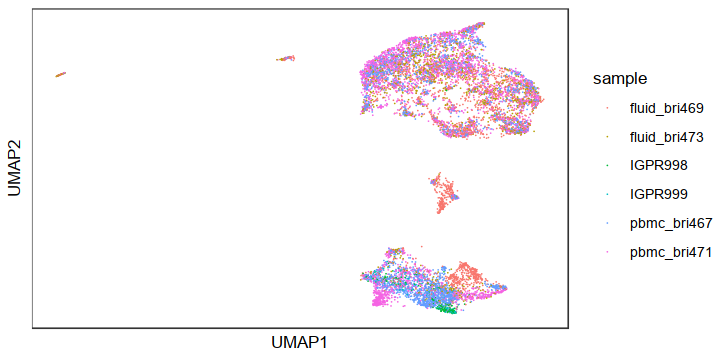

In [20]:
options(repr.plot.height = 3, repr.plot.width = 6)
ggplot() +
  geom_point(
    data = test[sample(nrow(test)),],
#     mapping = aes_string(x = "UMAP1_tis_sam", y = "UMAP2_tis_sam", fill = "sample"),
    mapping = aes_string(x = "UMAP1", y = "UMAP2", fill = "sample"),
    size = 0.2, stroke = 0.0001, shape = 21
  ) +
#   scale_fill_manual(values = meta_colors$sample, name = "") +
  theme_bw(base_size = 10) +
  theme(
#     legend.position = "none",
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", size=30)
  ) 


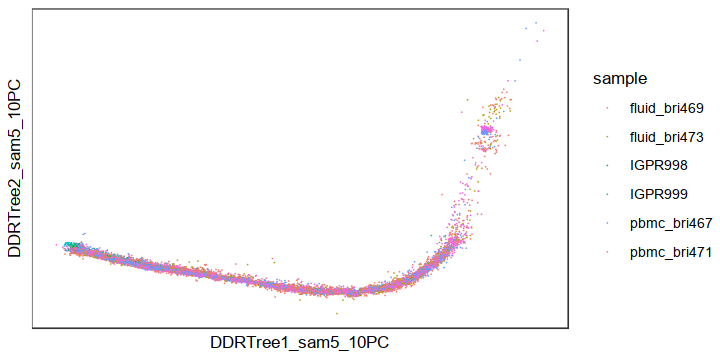

In [21]:
options(repr.plot.height = 3, repr.plot.width = 6)
ggplot() +
  geom_point(
    data = test[sample(nrow(test)),],
    mapping = aes_string(x = "DDRTree1_sam5_10PC", y = "DDRTree2_sam5_10PC", fill = "sample"),
    size = 0.2, stroke = 0.0001, shape = 21
  ) +
#   scale_fill_manual(values = meta_colors$sample, name = "") +
  theme_bw(base_size = 10) +
  theme(
#     legend.position = "none",
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", size=30)
  ) 


In [22]:
h_P012_fluid_470 <- readRDS("h_P012_fluid_470.rds")
h_P090_fluid_474 <- readRDS("h_P090_fluid_474.rds")

h_P012_fluid_470$cell <- h_P012_fluid_470$barcode
h_P012_fluid_470$cell <- substring(h_P012_fluid_470$cell, 16)
h_P012_fluid_470$cell <- paste0("fluid_bri469", h_P012_fluid_470$cell, sep ="") # bri469 - bri470

h_P090_fluid_474$cell <- h_P090_fluid_474$barcode
h_P090_fluid_474$cell <- substring(h_P090_fluid_474$cell, 16)
h_P090_fluid_474$cell <- paste0("fluid_bri473", h_P090_fluid_474$cell, sep ="") # bri473 - bri474


# h_P012_fluid_470[1:4,]

In [23]:
length(intersect(test$cell, h_P012_fluid_470$cell))

[1] 372

In [24]:
# Label the cells with expanded clones
test$clone <- rep("NO", nrow(test))
test[which(test$cell %in% h_P012_fluid_470$cell), ]$clone <- "clones_P012_fluid_470"
test[which(test$cell %in% h_P090_fluid_474$cell), ]$clone <- "clones_P090_fluid_474"
table(test$clone)


clones_P012_fluid_470 clones_P090_fluid_474                    NO 
                  372                    85                  9380 

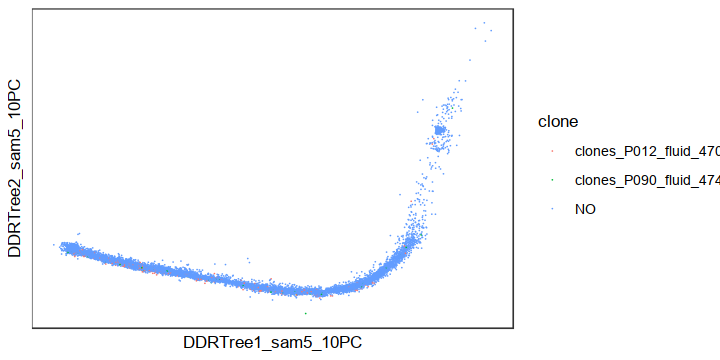

In [37]:
options(repr.plot.height = 3, repr.plot.width = 6)
ggplot() +
  geom_point(
    data = test[order(test$clone),],
    mapping = aes_string(x = "DDRTree1_sam5_10PC", y = "DDRTree2_sam5_10PC", fill = "clone"),
    size = 0.2, stroke = 0.0001, shape = 21
  ) +
#   scale_fill_manual(values = meta_colors$sample, name = "") +
  theme_bw(base_size = 10) +
  theme(
#     legend.position = "none",
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", size=30)
  ) 


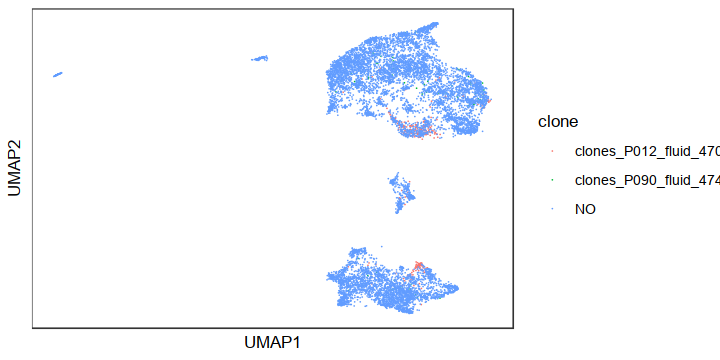

In [25]:
options(repr.plot.height = 3, repr.plot.width = 6)
ggplot() +
  geom_point(
    data = test[order(test$clone),],
#     mapping = aes_string(x = "UMAP1_tis_sam", y = "UMAP2_tis_sam", fill = "clone"),
    mapping = aes_string(x = "UMAP1", y = "UMAP2", fill = "clone"),
    size = 0.2, stroke = 0.0001, shape = 21
  ) +
#   scale_fill_manual(values = meta_colors$sample, name = "") +
  theme_bw(base_size = 10) +
  theme(
#     legend.position = "none",
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", size=30)
  ) 
